# Experiments with dynamic mode decomposition (DMD) interpretation of place and grid cells

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import torch
import torch.nn as nn
import numpy as np

from tqdm import tqdm

from neurodmd.training import train, test
from neurodmd.utils import StepwiseScheduler
from neurodmd.bump_simulator import PlaceGridMotionSimulator
from neurodmd.naive_model import PlaceGridSystemNonBio
from neurodmd.naive_model_cplx import PlaceGridSystemNonBioCplx

## Test dataset generation

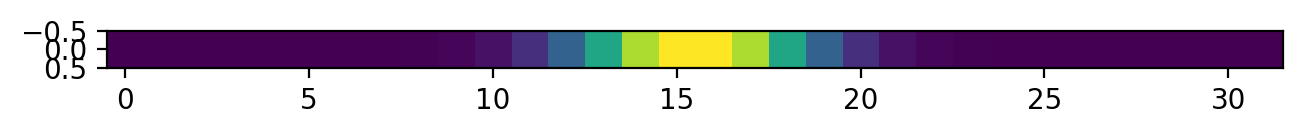

In [2]:
torch.manual_seed(0)
simulator = PlaceGridMotionSimulator(32, sigma=2)

fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(simulator()[None, :])

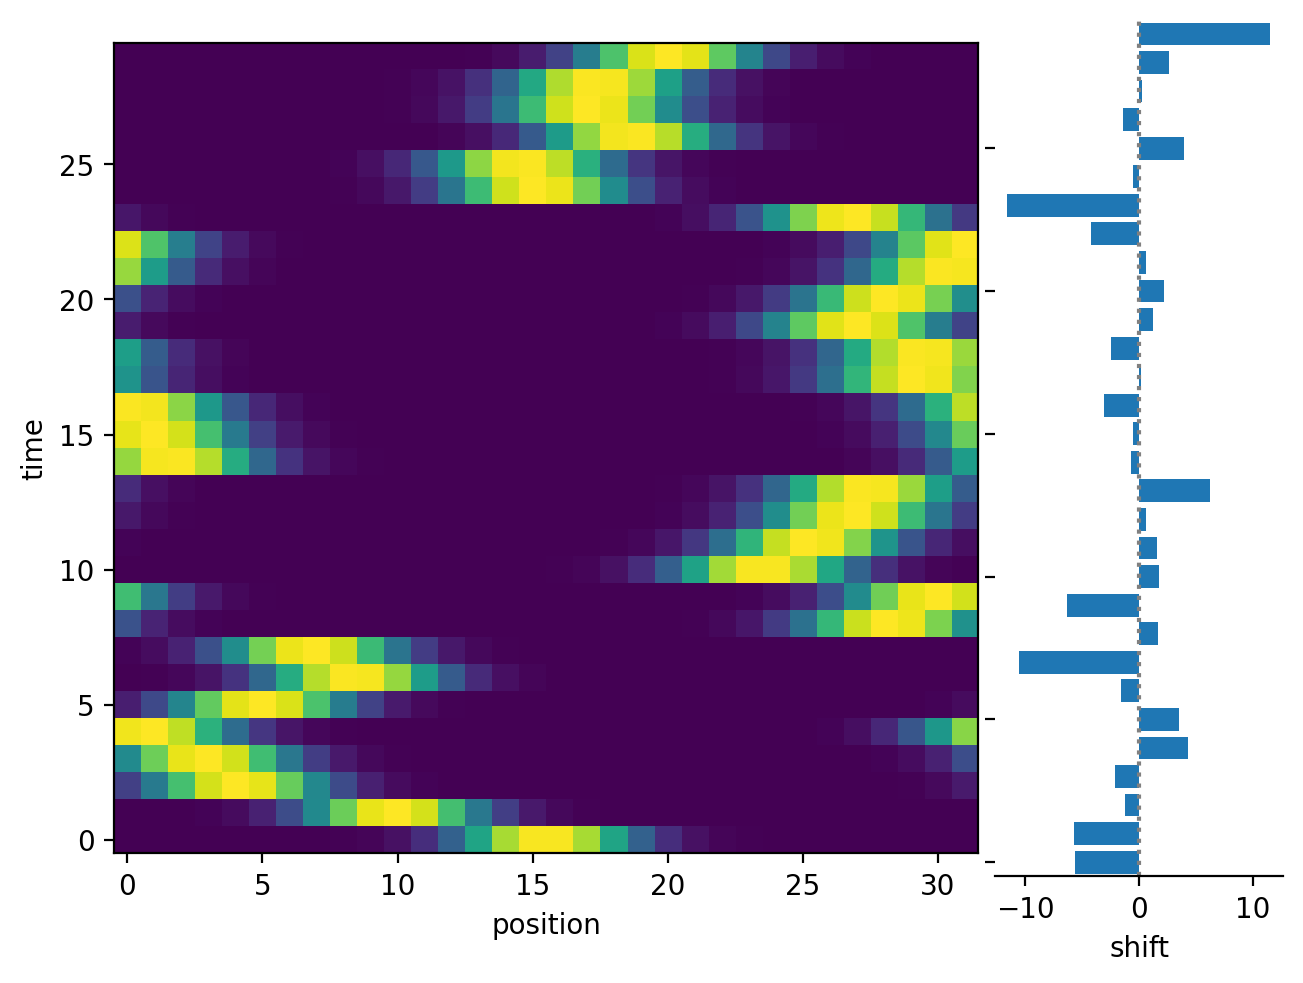

In [3]:
torch.manual_seed(0)
simulator = PlaceGridMotionSimulator(32, sigma=2)

crt_s = torch.normal(torch.zeros(30), 5.0)
crt_batch = simulator.batch(crt_s)

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(crt_batch)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=crt_s, y=np.arange(len(crt_s)))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

## Generate a dataset with periodic boundary conditions

In [4]:
torch.manual_seed(0)

n = 32
simulator = PlaceGridMotionSimulator(n, sigma=2)

n_samples = 150_000
s = torch.normal(torch.zeros(n_samples), 5.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 500
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

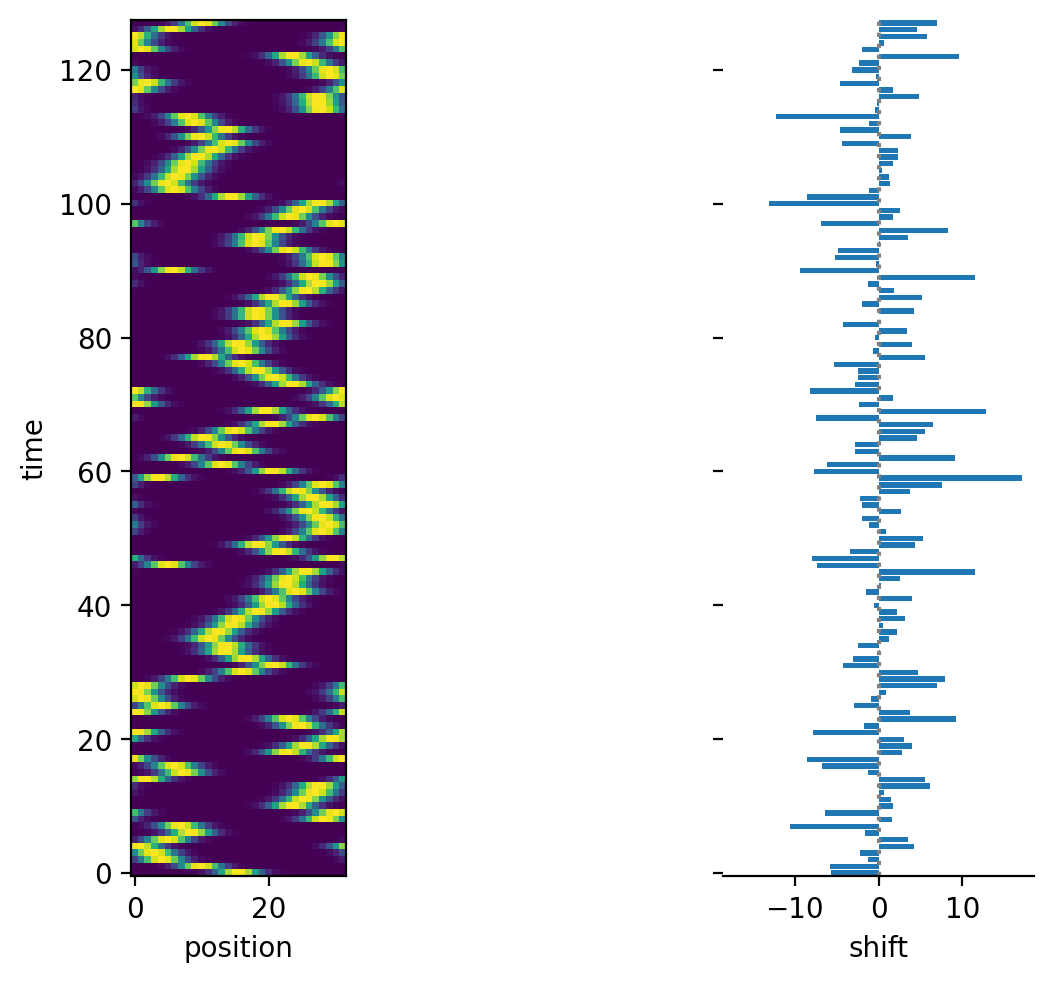

In [5]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

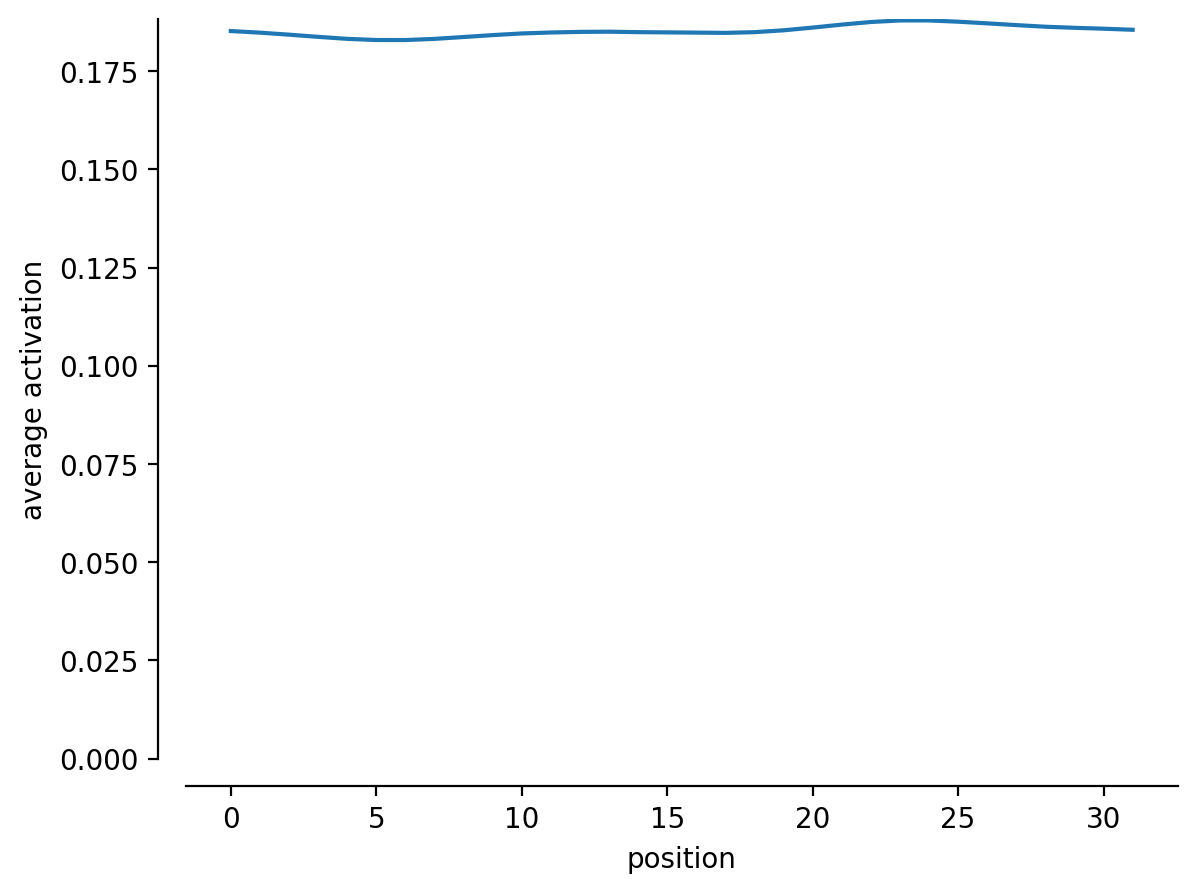

In [6]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Check that the generated patterns exactly match Fourier translations

In [7]:
crt_fourier_U = np.array(
    [
        [1 / np.sqrt(n) * np.exp(2 * np.pi * k * l / n * 1j) for k in range(n)]
        for l in range(n)
    ]
)
crt_fourier_V = crt_fourier_U.conj().T

In [8]:
(
    np.max(np.abs(crt_fourier_U @ crt_fourier_V - np.eye(n))),
    np.max(np.abs(crt_fourier_V @ crt_fourier_U - np.eye(n))),
)

(3.243653198645024e-15, 4.099017829071558e-15)

In [9]:
def fourier_translate(x: np.ndarray, s: float) -> np.ndarray:
    n = len(x)
    # turns out the ** operator has the right branch cut to maket this work
    lbd = np.exp(-(2j * np.pi / n) * np.arange(n)) ** s

    # need to zero out highest frequency mode if n is even
    if n % 2 == 0:
        lbd[n // 2] = 0

    x_f = crt_fourier_V @ x
    x_f_shifted = lbd * x_f
    x_shifted = crt_fourier_U @ x_f_shifted
    
    assert np.max(np.abs(x_shifted.imag)) < 1e-6

    return x_shifted.real

In [10]:
crt_errors = []
for x, y, s in dataset_full:
    x = x.detach().numpy()
    y = y.detach().numpy()
    s = s.item()

    y_pred = fourier_translate(x, s)
    crt_errors.append(np.linalg.norm(y - y_pred))

crt_errors = np.array(crt_errors)

In [11]:
np.quantile(crt_errors, [0.005, 0.025, 0.500, 0.975, 0.995])

array([8.46644854e-08, 6.36668649e-07, 2.11095389e-05, 9.90798814e-05,
       1.33687665e-04])

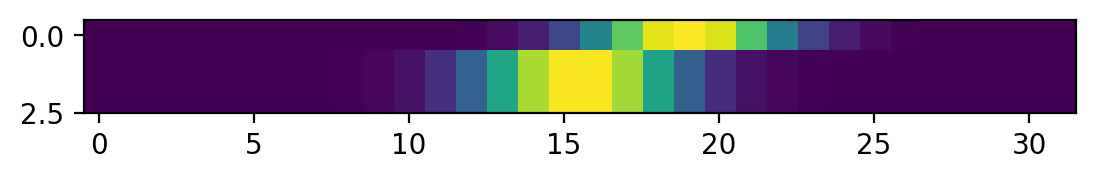

In [12]:
plt.imshow(np.vstack((x, y, y_pred)))

## Check that there is an exact solution for the simulated patterns using our model class

### Complex-valued version

#### Check that a model initialized at Fourier solution yields (almost) zero loss

In [13]:
test_system = PlaceGridSystemNonBioCplx(n, n - 1)
sys_U_torch = torch.from_numpy(np.copy(crt_fourier_V)).type(torch.complex64)
sys_V_torch = torch.from_numpy(np.copy(crt_fourier_U)).type(torch.complex64)
test_system.U = torch.vstack((sys_U_torch[: n // 2, :], sys_U_torch[n // 2 + 1 :, :]))
test_system.V = torch.hstack((sys_V_torch[:, : n // 2], sys_V_torch[:, n // 2 + 1 :]))

crt_lbd = torch.exp(-(2j * np.pi / n) * torch.arange(n))
test_system.lbd = torch.hstack((crt_lbd[: n // 2], crt_lbd[n // 2 + 1 :]))

# this doesn't really matter for the math, but for consistency: let's put c.c. pairs
# next to each other
crt_order = torch.hstack(
    (
        torch.IntTensor([0]),
        torch.stack(
            (torch.arange(1, n // 2), torch.arange(n - 2, n // 2 - 1, - 1))
        ).T.ravel(),
    )
)
test_system.U = test_system.U[crt_order, :]
test_system.V = test_system.V[:, crt_order]
test_system.lbd = test_system.lbd[crt_order]

crt_scores = []
for x, y, s in dataset_full:
    crt_loss = test_system.loss(x[None, :], y[None, :], s[None]).item()
    crt_scores.append(crt_loss)

crt_scores = np.array(crt_scores)

In [14]:
np.quantile(crt_scores, [0.005, 0.025, 0.500, 0.975, 0.995])

array([2.00241024e-15, 9.53110314e-15, 6.95810336e-12, 1.53367274e-10,
       2.79715431e-10])

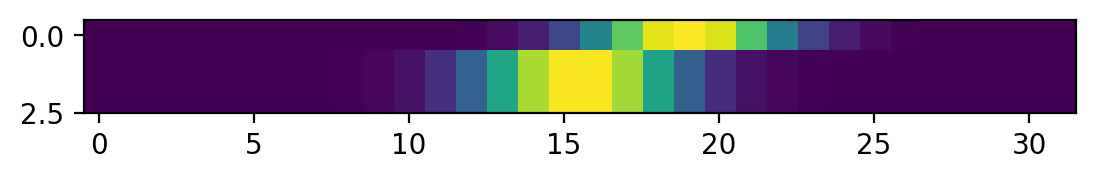

In [15]:
y_pred = test_system.propagate_place(x[None, :], s[None])
plt.imshow(np.vstack((x, y, y_pred)))

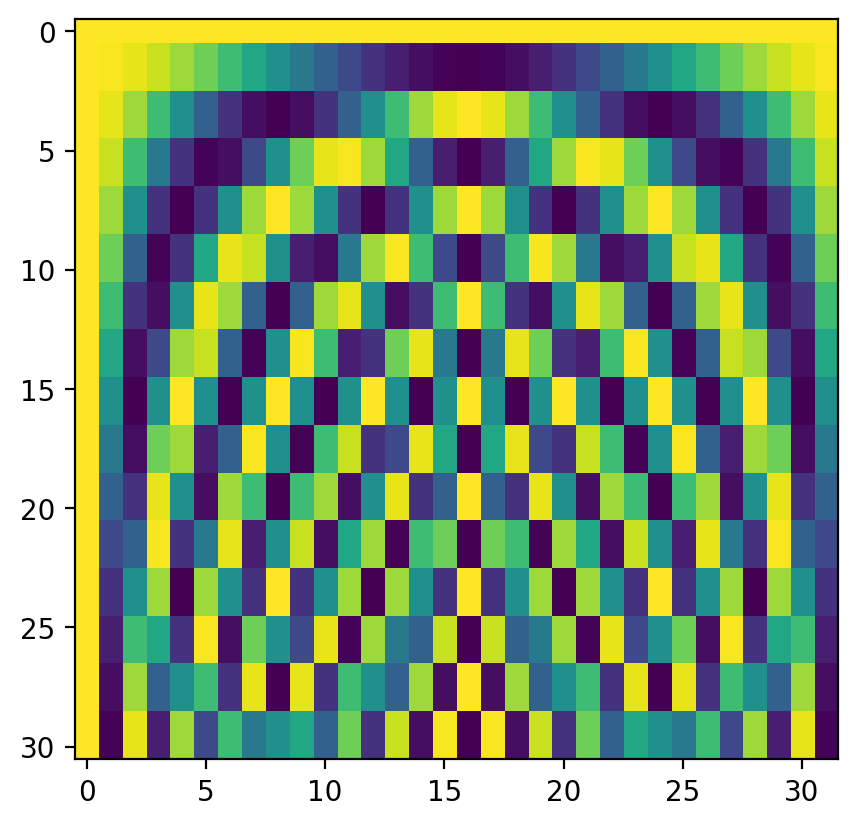

In [16]:
plt.imshow(test_system.U.real)

#### Sanity check: projection to valid parameters does not spoil global optimum

In [17]:
crt_old_U = torch.clone(test_system.U)
crt_old_V = torch.clone(test_system.V)
crt_old_lbd = torch.clone(test_system.lbd)

test_system.project_to_real()

assert torch.allclose(crt_old_U, test_system.U)
assert torch.allclose(crt_old_V, test_system.V)
assert torch.allclose(crt_old_lbd, test_system.lbd)

#### Sanity check: gradient (almost) zero at global optimum

In [18]:
test_system.U.requires_grad = True
test_system.V.requires_grad = True
test_system.lbd.requires_grad = True

test_system.train()

crt_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=200)
crt_iter = iter(crt_dataloader)
crt_data, crt_target, crt_shift = next(crt_iter)

test_system.zero_grad()
crt_loss = test_system.loss(crt_data, crt_target, crt_shift)
crt_loss.backward()

assert torch.max(torch.abs(crt_loss)) < 1e-9

assert torch.max(torch.abs(test_system.U.grad)) < 1e-9
assert torch.max(torch.abs(test_system.V.grad)) < 1e-9
assert torch.max(torch.abs(test_system.lbd.grad)) < 1e-6

#### Sanity check: SGD optimization does not lead us away from global optimum

In [19]:
batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

test_system.U.requires_grad = True
test_system.V.requires_grad = True
test_system.lbd.requires_grad = True

test_optimizer = torch.optim.SGD(test_system.parameters(), lr=0.001)
test_scheduler = torch.optim.lr_scheduler.StepLR(
    test_optimizer, step_size=10, gamma=0.995
)
test_train_results = train(
    test_system,
    "cpu",
    dataloader_train,
    test_optimizer,
    test_set=dataloader_test,
    test_every=200,
    scheduler=test_scheduler,
)

100%|██████████| 149499/149499 [00:01<00:00, 91354.52it/s, train batch loss: 0.000000]


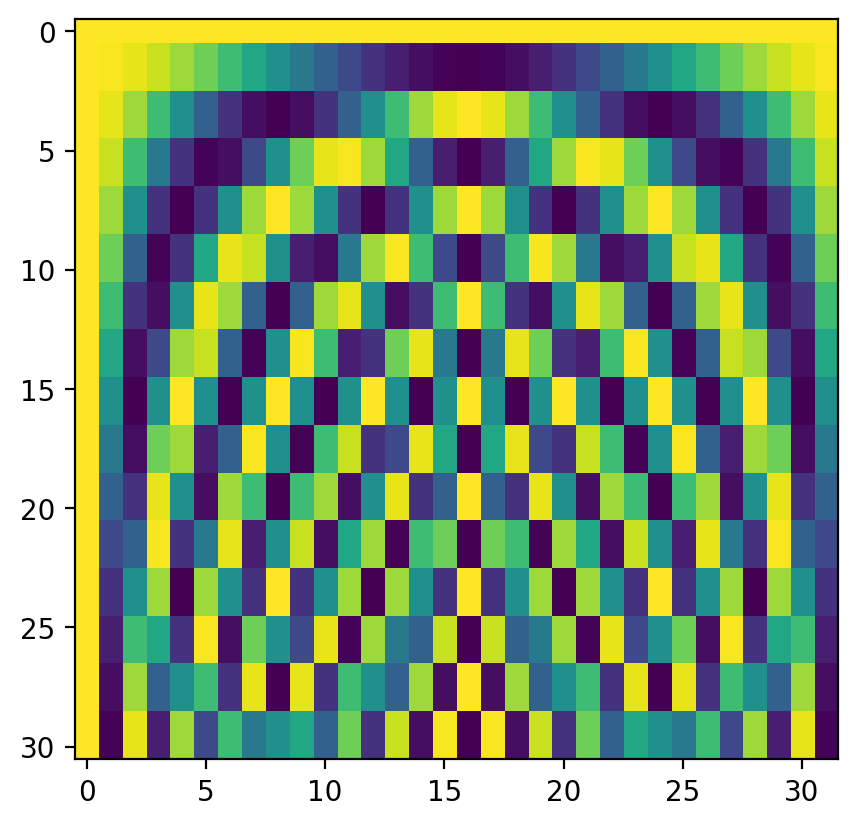

In [20]:
plt.imshow(test_system.U.real.detach())

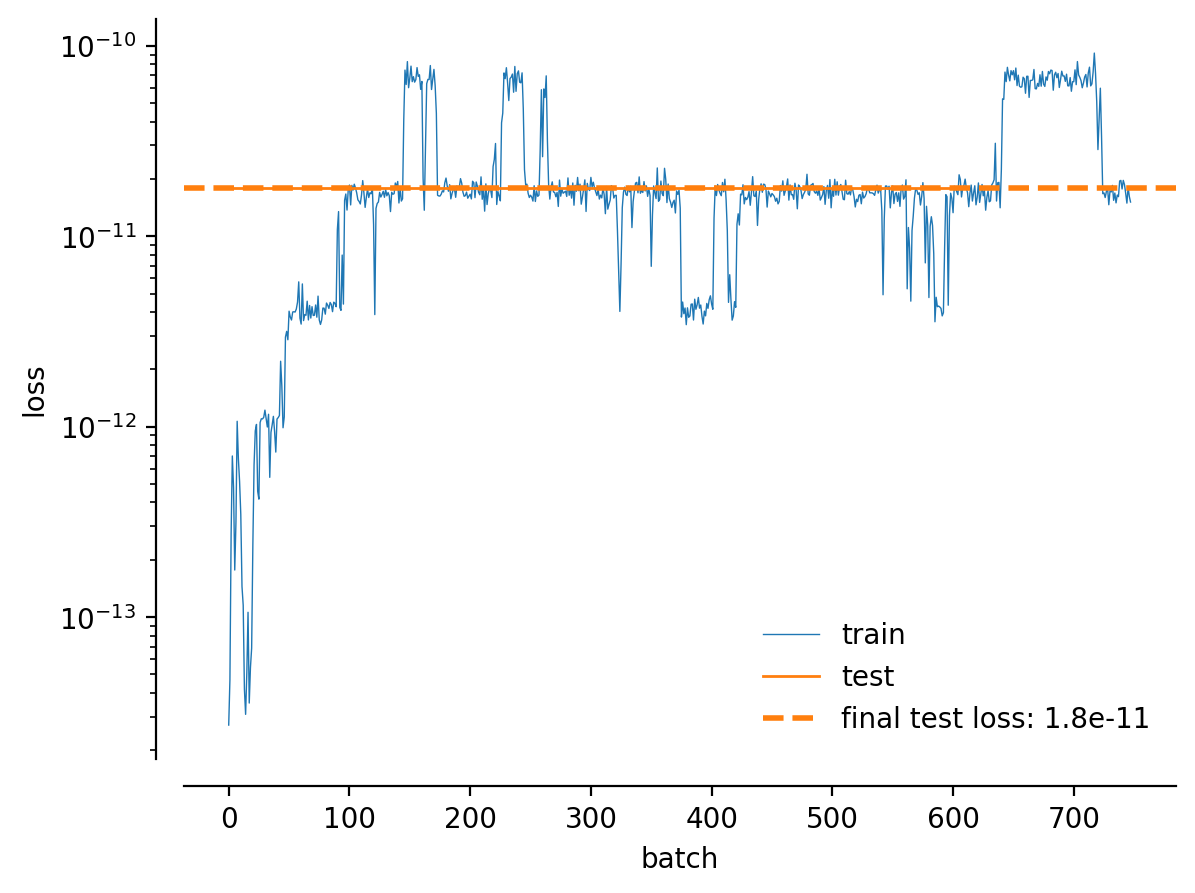

In [21]:
fig, ax = plt.subplots()
ax.semilogy(test_train_results.train_loss, lw=0.5, label="train")
ax.semilogy(
    test_train_results.test_idxs, test_train_results.test_loss, lw=1.0, label="test"
)
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    test_train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {test_train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

### TODO: Checks for real-valued version

## Try learning

### Complex-valued version

In [22]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBioCplx(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_lbd = torch.clone(system.lbd).detach()

optimizer = torch.optim.Adagrad(system.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
scheduler = StepwiseScheduler(optimizer, [(50, 0.05), (100, 0.2), (100, 0.3), (250, 0.1)])

train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 149499/149499 [00:01<00:00, 91063.42it/s, train batch loss: 0.009079]


In [23]:
scheduler.get_last_lr()

[0.1]

In [24]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.lbd - original_lbd)),
)

(tensor(0.1464, grad_fn=<MedianBackward0>),
 tensor(0.1868, grad_fn=<MedianBackward0>),
 tensor(0.1385, grad_fn=<MedianBackward0>))

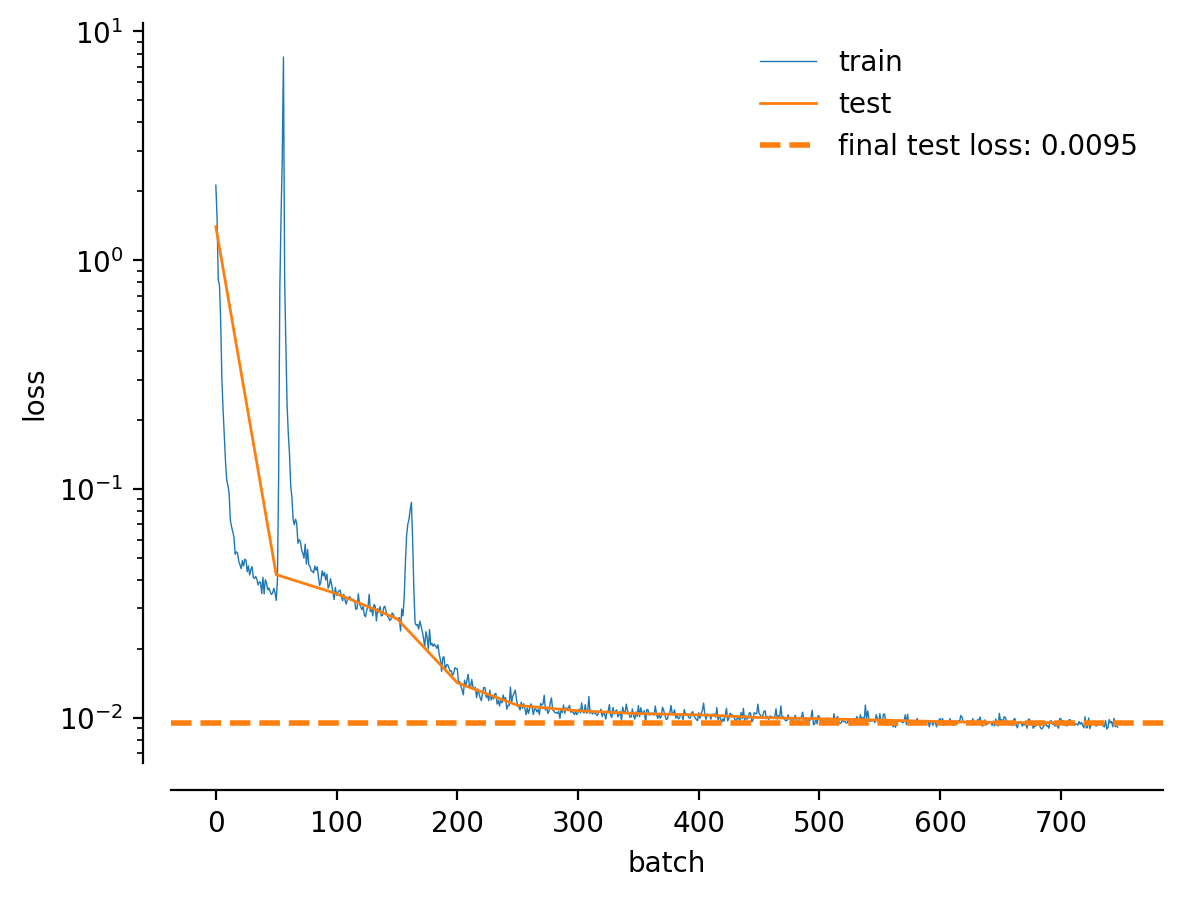

In [25]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

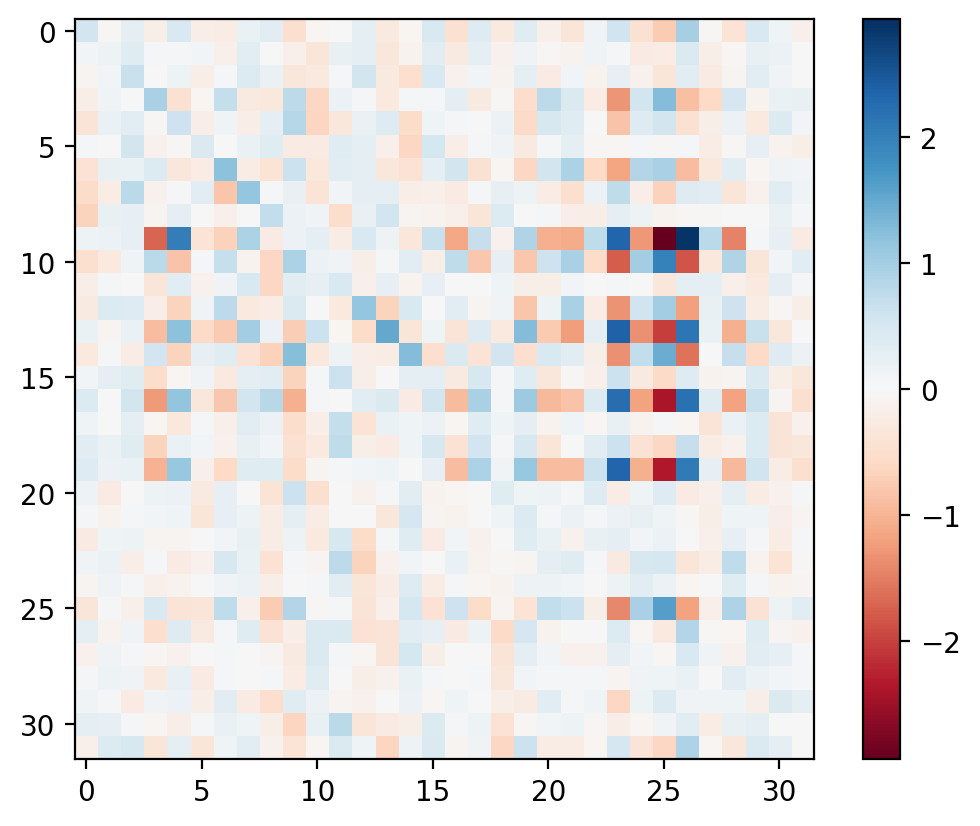

In [26]:
crt_tensor = torch.real(system.V @ system.U).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

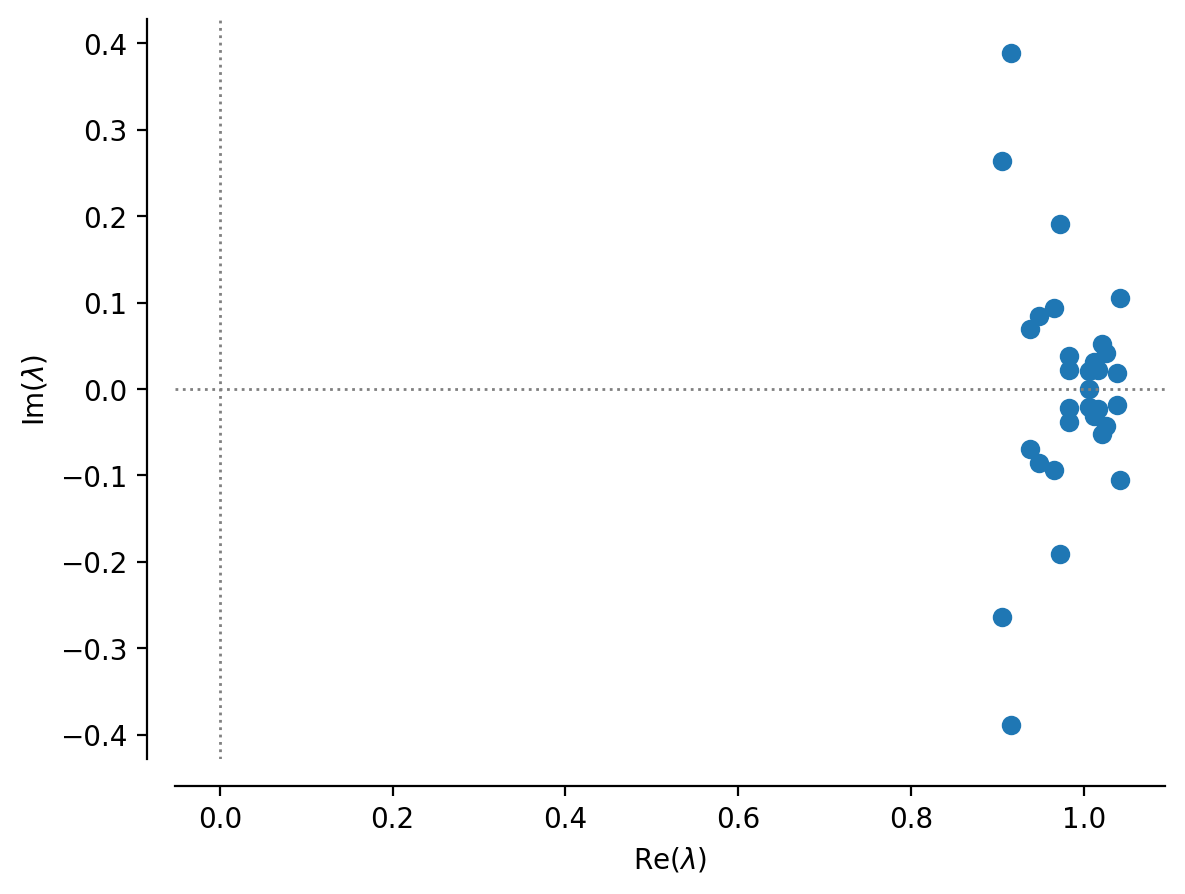

In [27]:
fig, ax = plt.subplots()
crt_v = system.lbd.detach().numpy()

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [28]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(2.4262, grad_fn=<MaxBackward1>),
 tensor(1.5592, grad_fn=<MaxBackward1>))

#### Try learned system on examples

In [29]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=2)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [30]:
test_moved = system.propagate_place(test_trajectory, 3 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

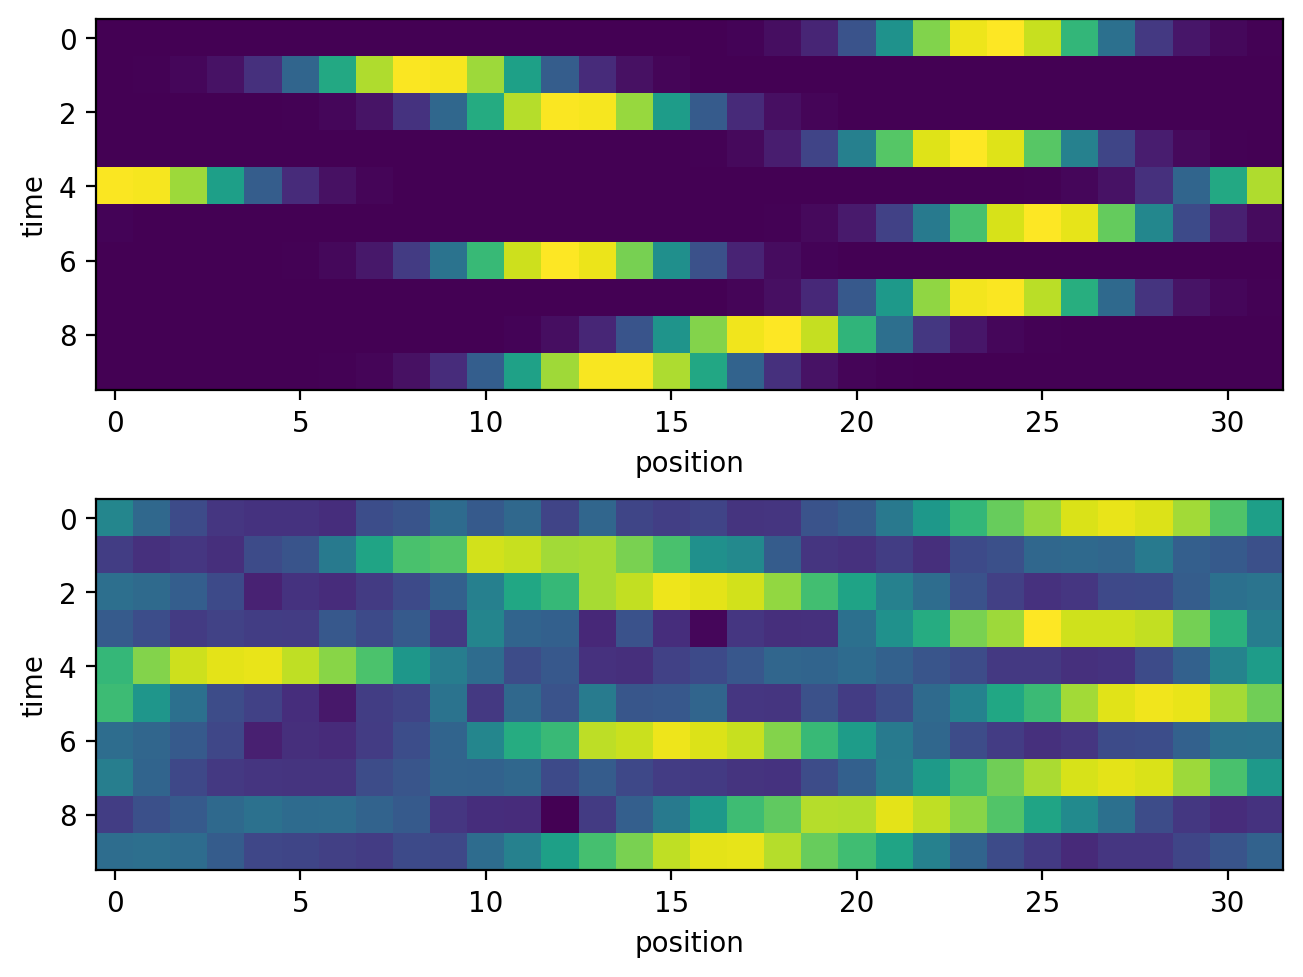

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [32]:
[torch.min(torch.abs(system.lbd)), torch.max(torch.abs(system.lbd))]

[tensor(0.9396, grad_fn=<MinBackward1>),
 tensor(1.0475, grad_fn=<MaxBackward1>)]

Text(0.5, 0, 'Im')

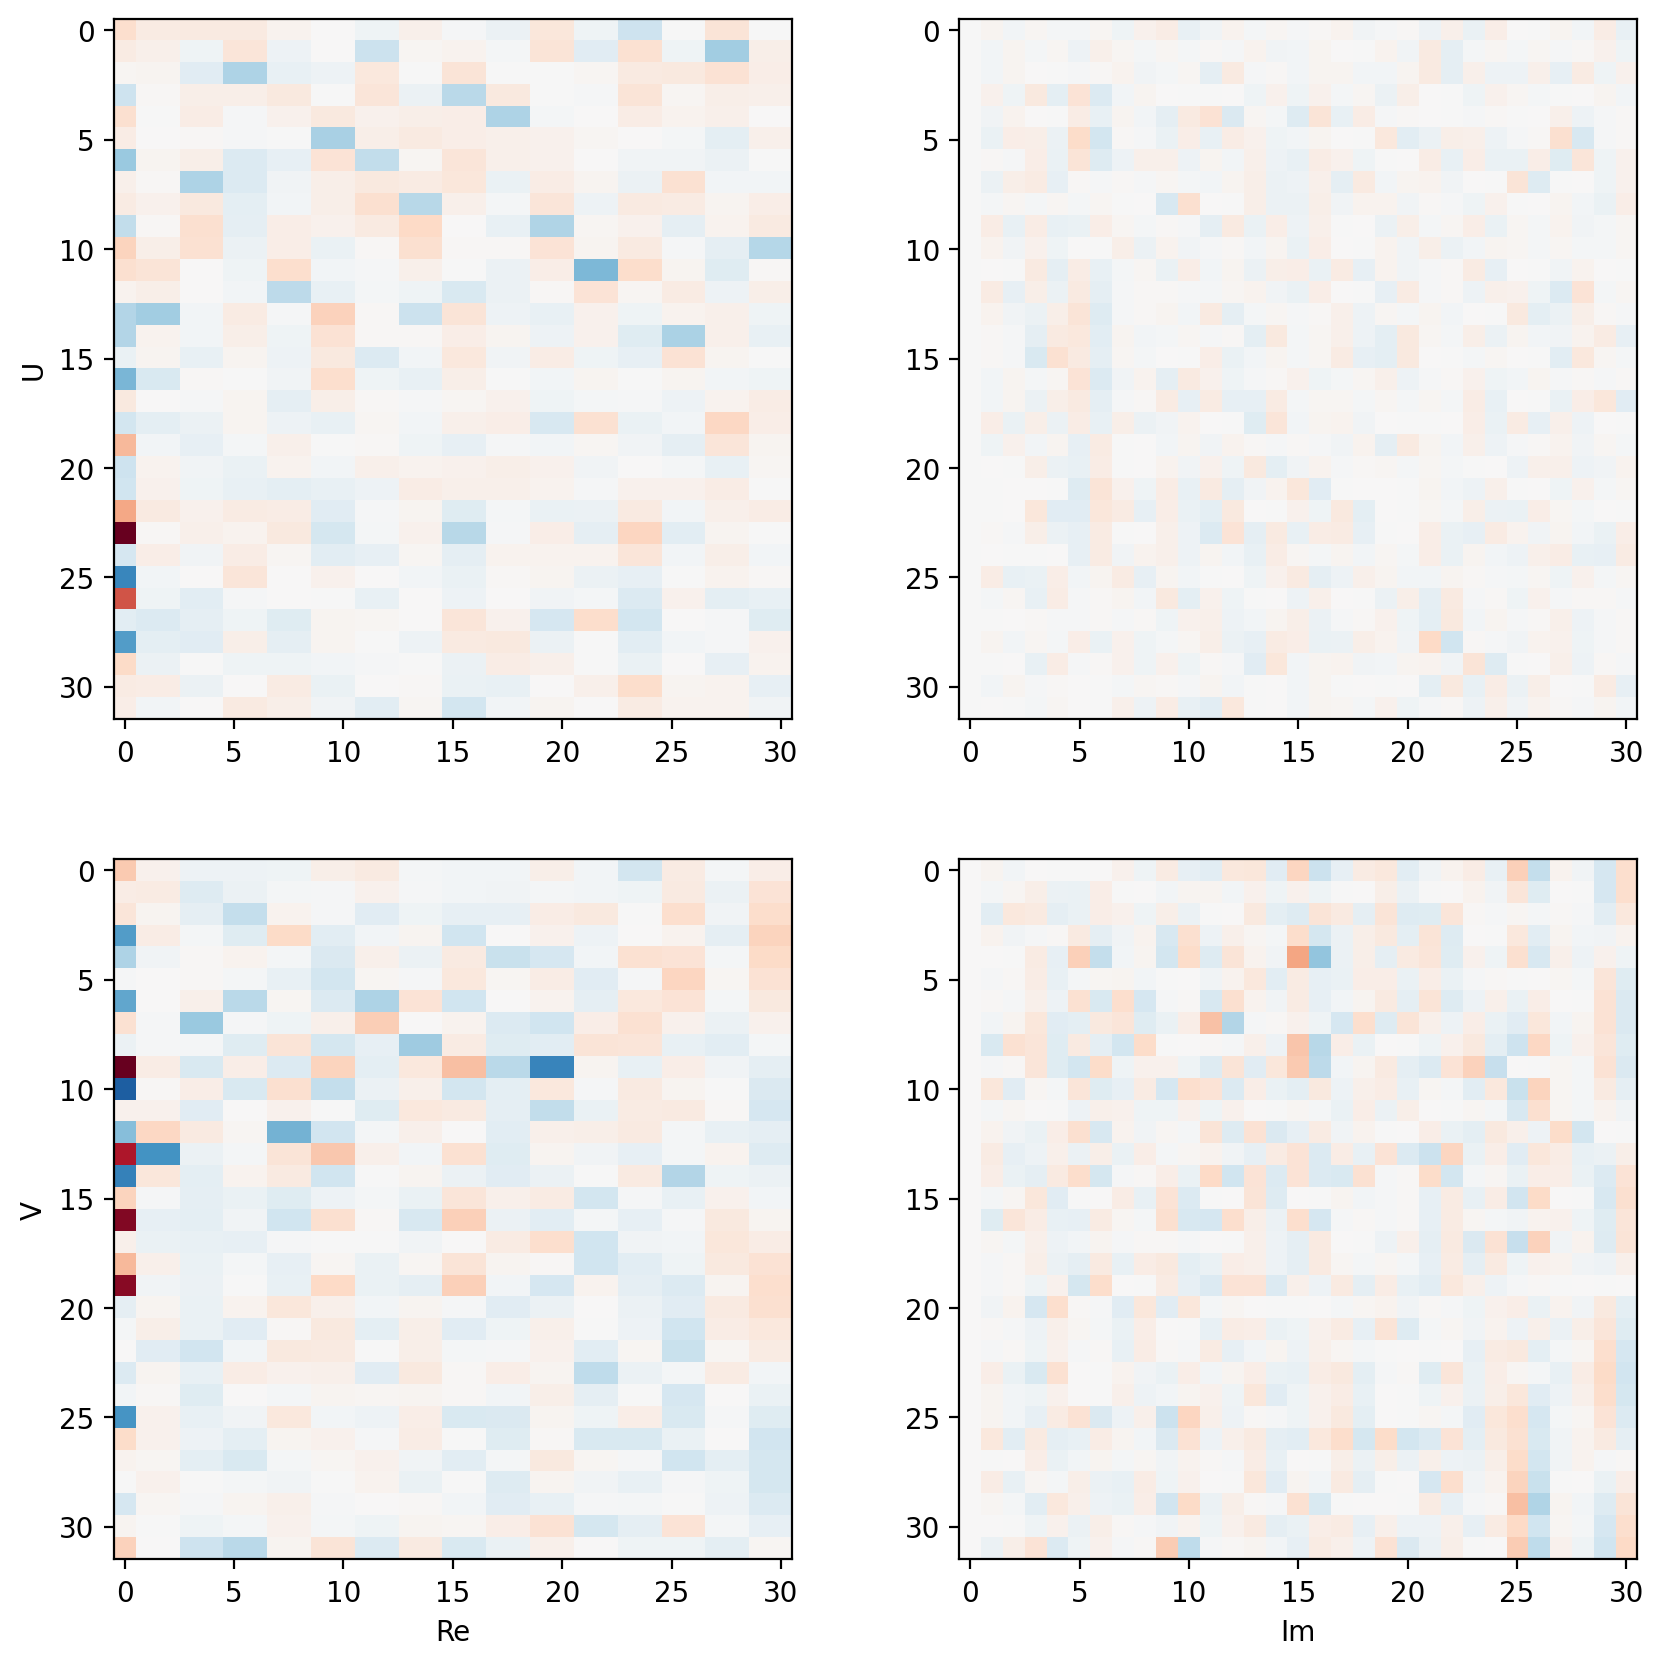

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
crt_d = {"U": system.U.T, "V": system.V}
crt_ordering = np.argsort(np.abs(np.angle(system.lbd.detach().numpy())))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))

    ax_row = axs[i]
    ax_row[0].imshow(crt_mat.real, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")
    ax_row[1].imshow(crt_mat.imag, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax_row[0].set_ylabel(crt_name)

axs[1, 0].set_xlabel("Re")
axs[1, 1].set_xlabel("Im")

### Real-valued version

In [34]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.Adagrad(system.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(optimizer, [(50, 0.05), (100, 0.2), (100, 0.3), (250, 0.1)])
scheduler = None

train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 149499/149499 [03:19<00:00, 747.60it/s, train batch loss: 0.001686]


In [35]:
# scheduler.get_last_lr()

In [36]:
(
    torch.max(torch.abs(system.U - original_U)),
    torch.max(torch.abs(system.V - original_V)),
    torch.max(torch.abs(system.xi - original_xi)),
    torch.max(torch.abs(system.theta - original_theta)),
)

(tensor(0.3199, grad_fn=<MaxBackward1>),
 tensor(0.7083, grad_fn=<MaxBackward1>),
 tensor(0.1471, grad_fn=<MaxBackward1>),
 tensor(0.4641, grad_fn=<MaxBackward1>))

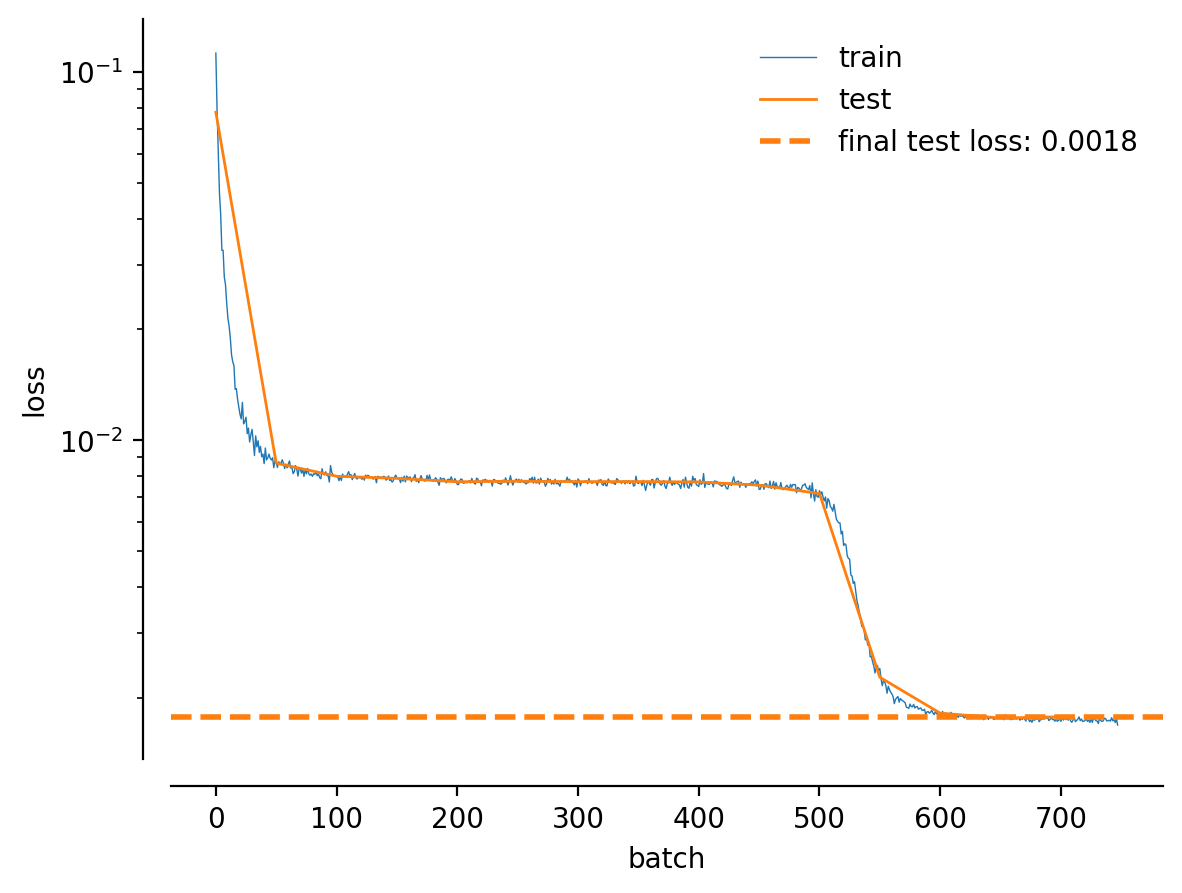

In [37]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

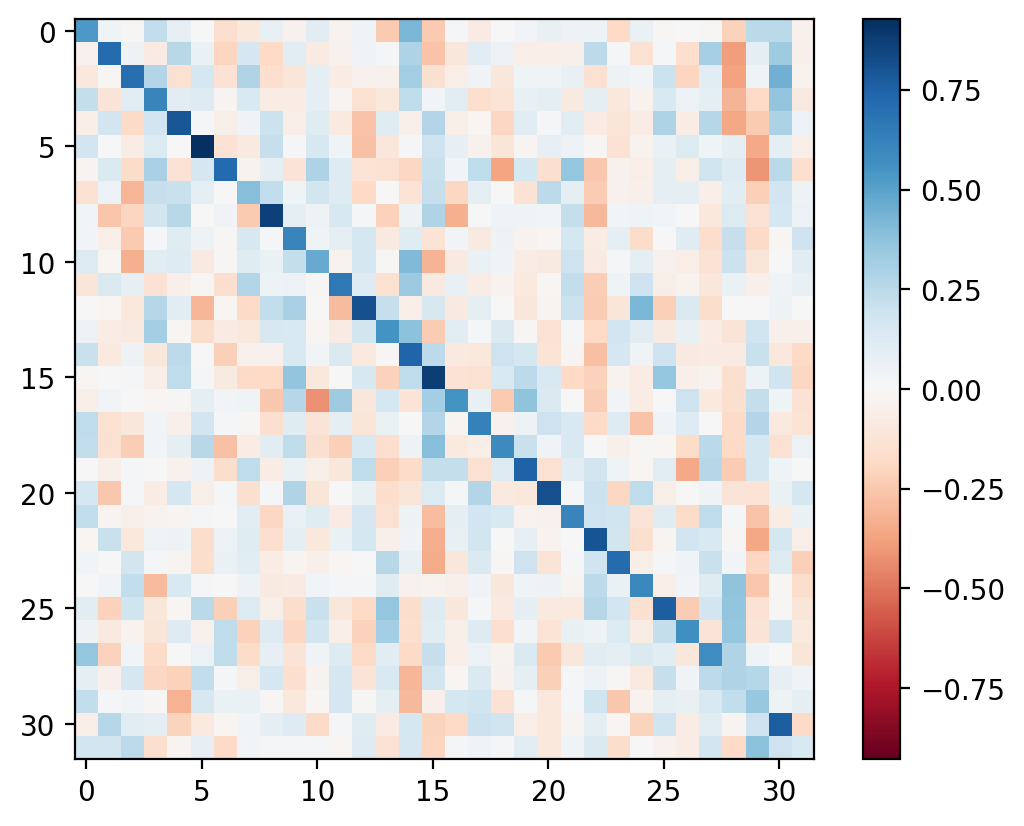

In [38]:
crt_tensor = (system.V @ system.U).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

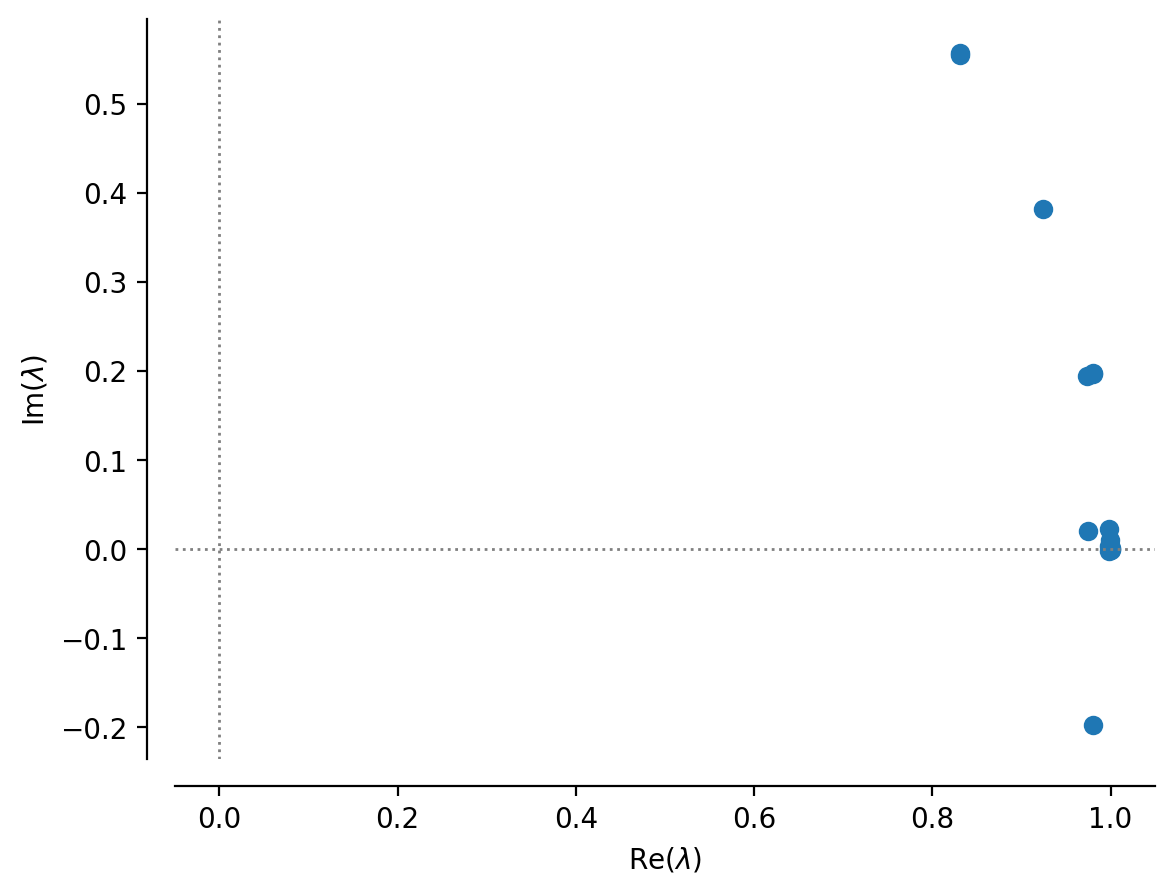

In [39]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [40]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.9309, grad_fn=<MaxBackward1>),
 tensor(1.0481, grad_fn=<MaxBackward1>))

#### Try learned system on examples

In [41]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=2)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [42]:
test_moved = system.propagate_place(test_trajectory, 3 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

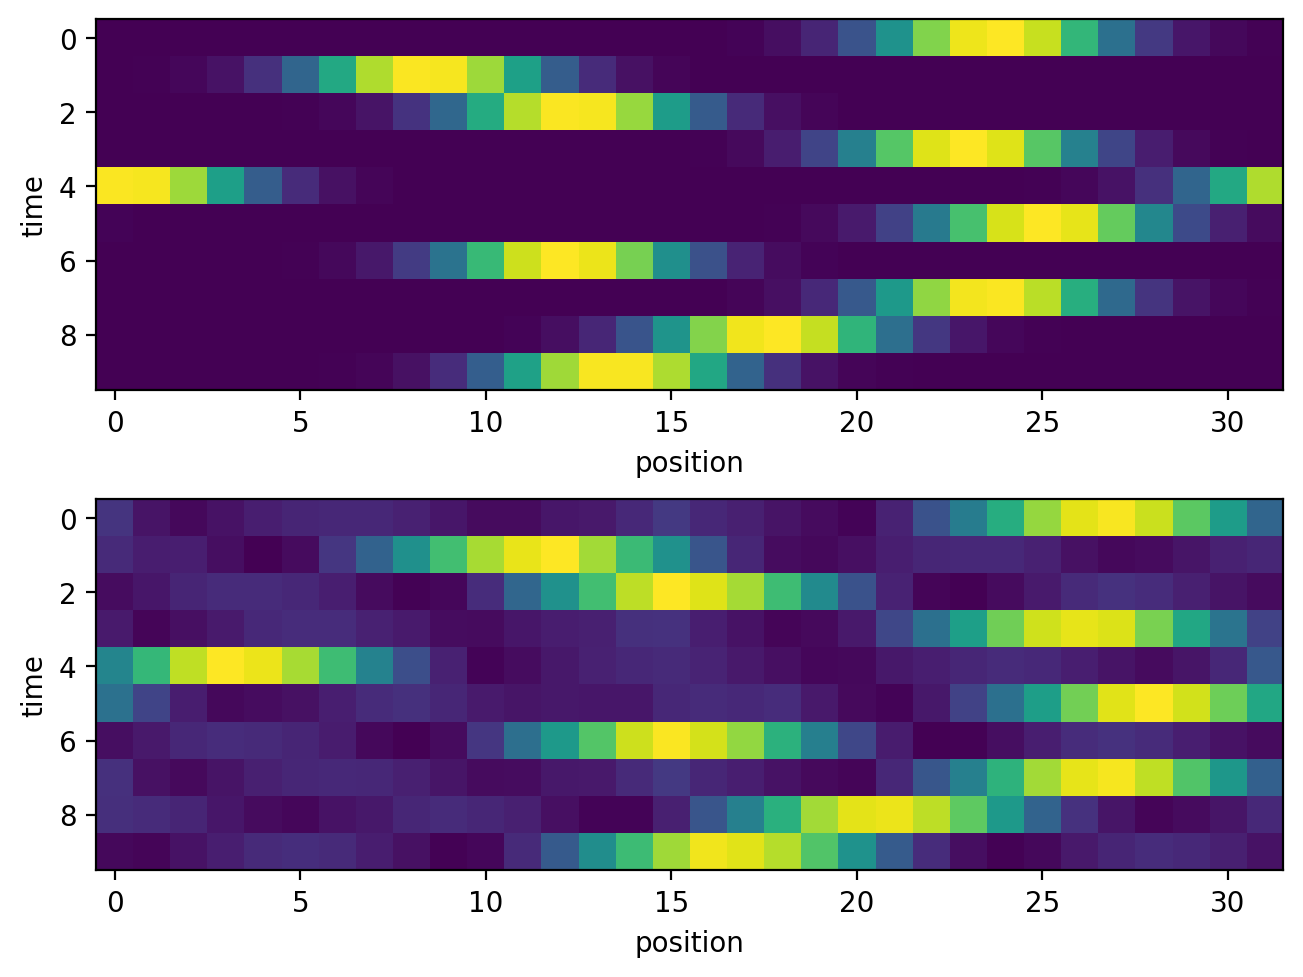

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [44]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(3.0380e-16, grad_fn=<MinBackward1>),
 tensor(0.2263, grad_fn=<MaxBackward1>)]

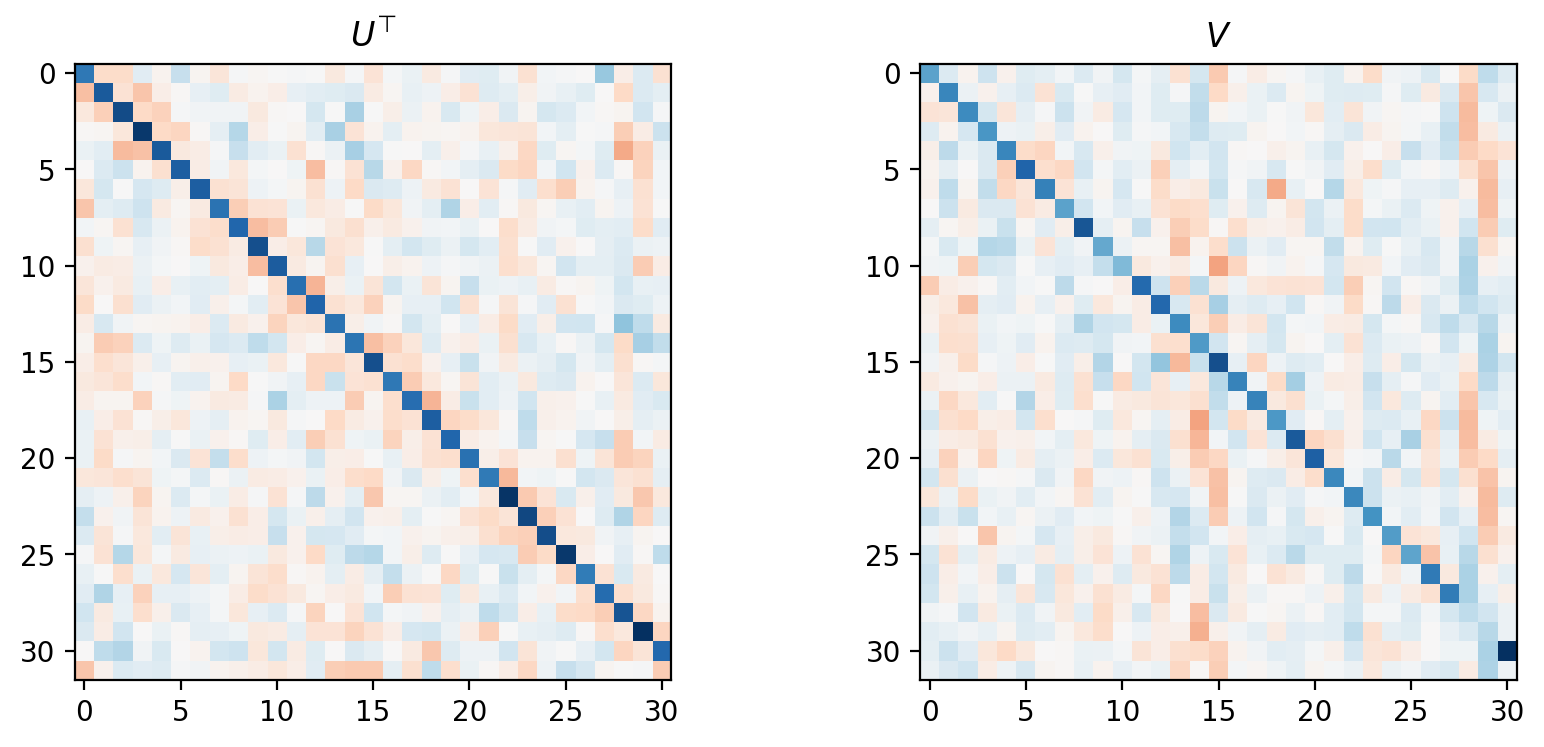

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

In [46]:
1 / np.cosh(system.xi.detach().numpy())

array([0.9999964 , 1.        , 1.        , 0.9985936 , 0.9928428 ,
       0.9749312 , 0.99957174, 0.9999999 , 0.9985654 , 0.999959  ,
       0.999796  , 1.        , 0.9986645 , 1.        , 0.999977  ,
       1.        ], dtype=float32)

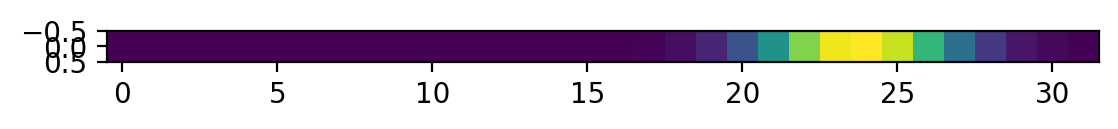

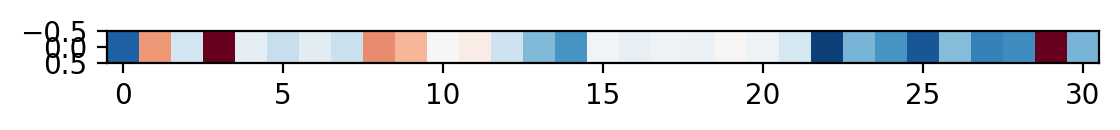

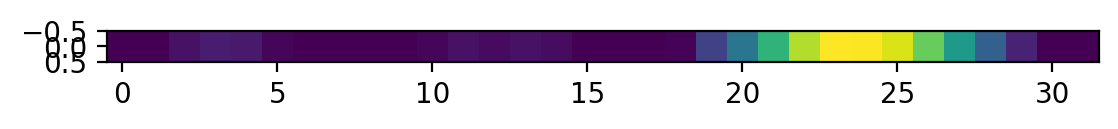

In [47]:
tmp = test_trajectory[0]
tmp_g = system.to_grid(tmp)
fig, ax = plt.subplots()
ax.imshow([tmp.numpy()], vmin=0)

fig, ax = plt.subplots()
crt_l = np.max(np.abs(tmp_g.detach().numpy()))
ax.imshow([tmp_g.detach().numpy()], vmin=-crt_l, vmax=crt_l, cmap="RdBu")

tmp_back = system.from_grid(tmp_g)
fig, ax = plt.subplots()
ax.imshow([tmp_back.detach().numpy()], vmin=0)

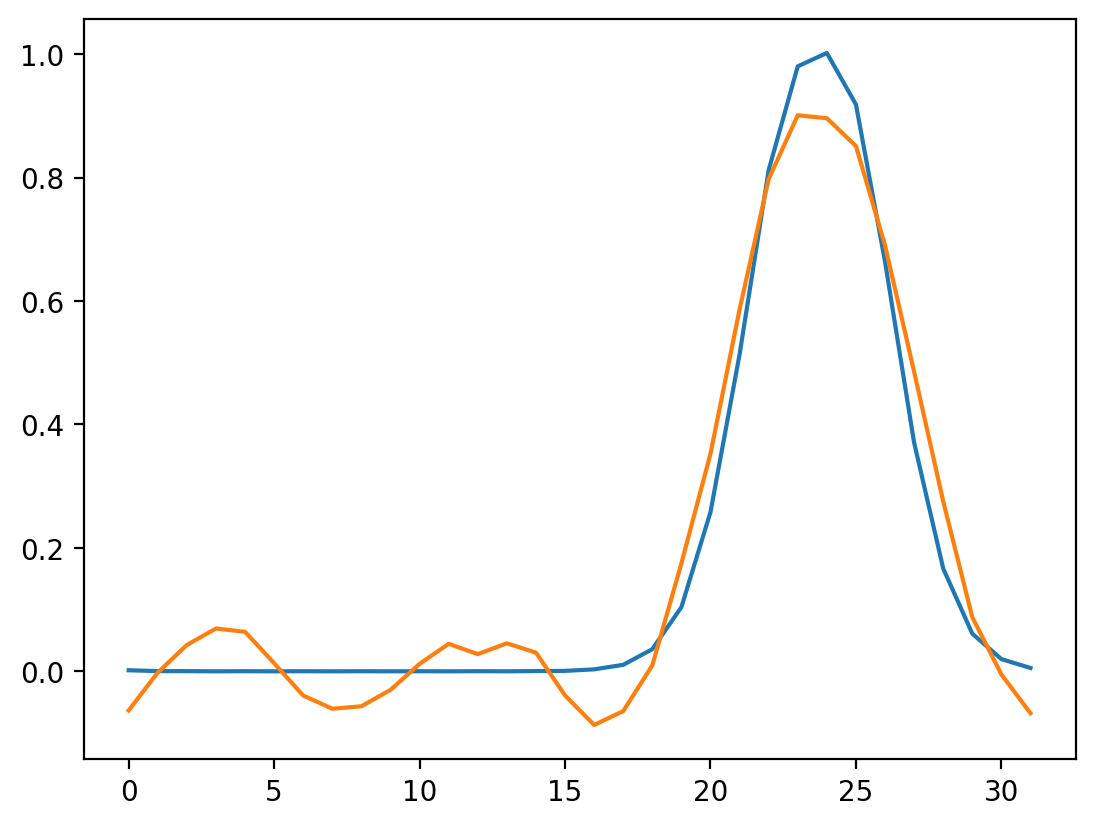

In [48]:
fig, ax = plt.subplots()
ax.plot(tmp.detach().numpy())
ax.plot(tmp_back.detach().numpy())

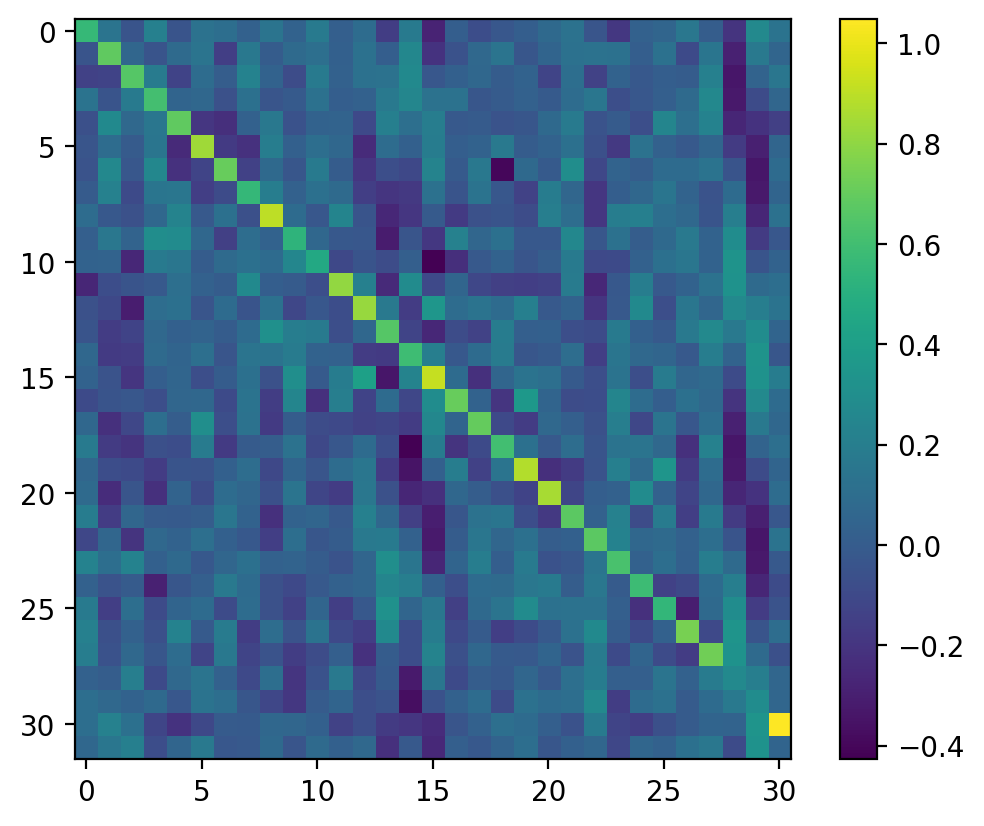

In [49]:
plt.imshow(system.V.detach().numpy())
plt.colorbar()

## Test learning on smaller system

In [50]:
torch.manual_seed(0)

n = 8
simulator = PlaceGridMotionSimulator(n, sigma=0.5)

n_samples = 500_000
s = torch.normal(torch.zeros(n_samples), 1.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 1000
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

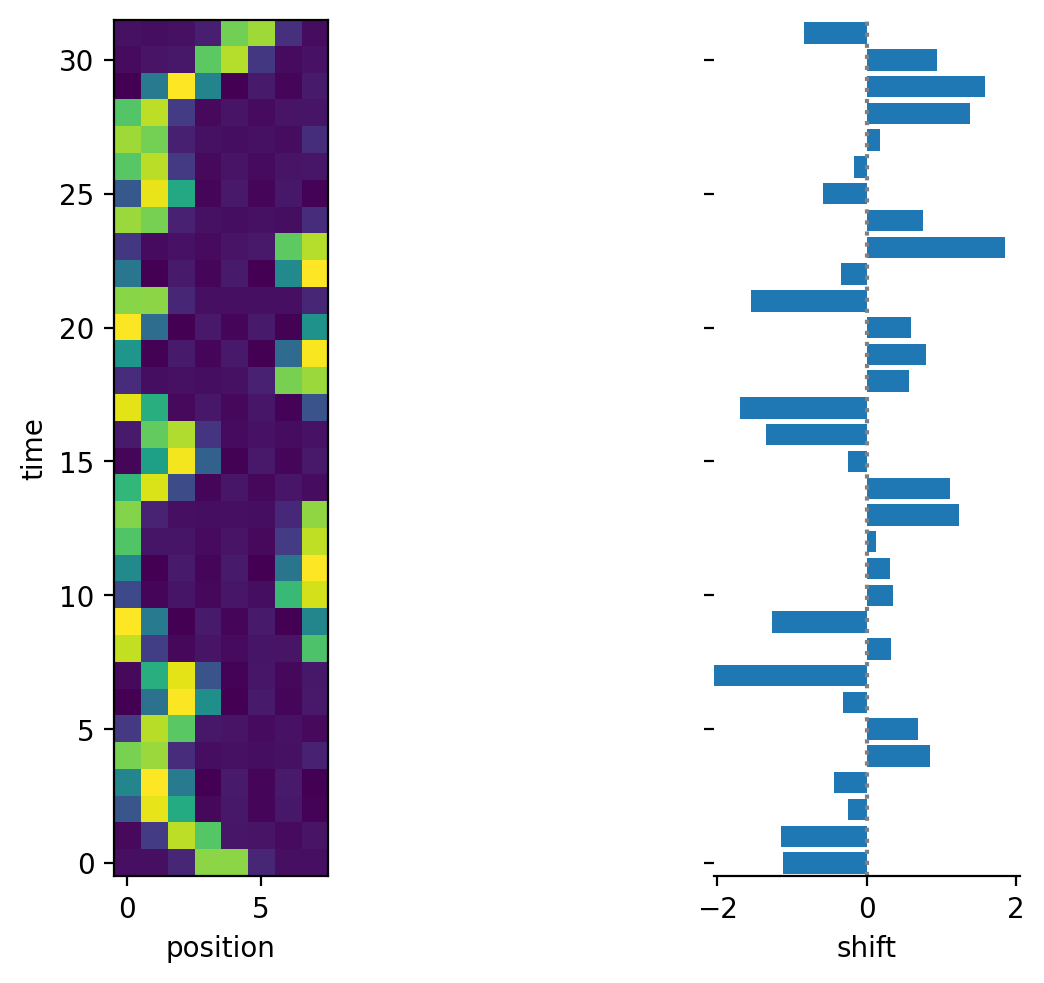

In [51]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

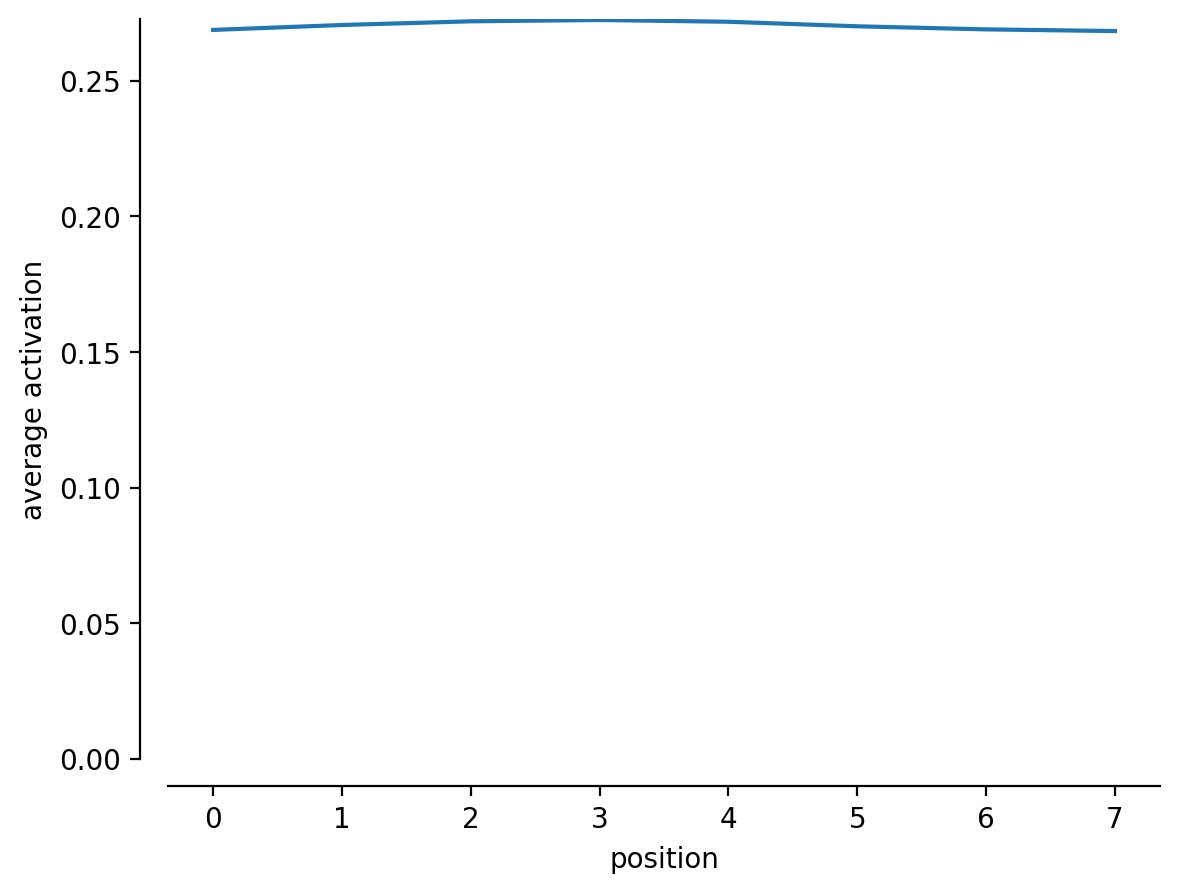

In [52]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Complex-valued simulation

In [53]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBioCplx(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_lbd = torch.clone(system.lbd).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
scheduler = StepwiseScheduler(
    optimizer,
    [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
)
# scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 498999/498999 [00:04<00:00, 114322.93it/s, train batch loss: 0.005641]


In [54]:
scheduler.get_last_lr()

[0.005]

In [55]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.lbd - original_lbd)),
)

(tensor(0.4565, grad_fn=<MedianBackward0>),
 tensor(0.3657, grad_fn=<MedianBackward0>),
 tensor(0.6981, grad_fn=<MedianBackward0>))

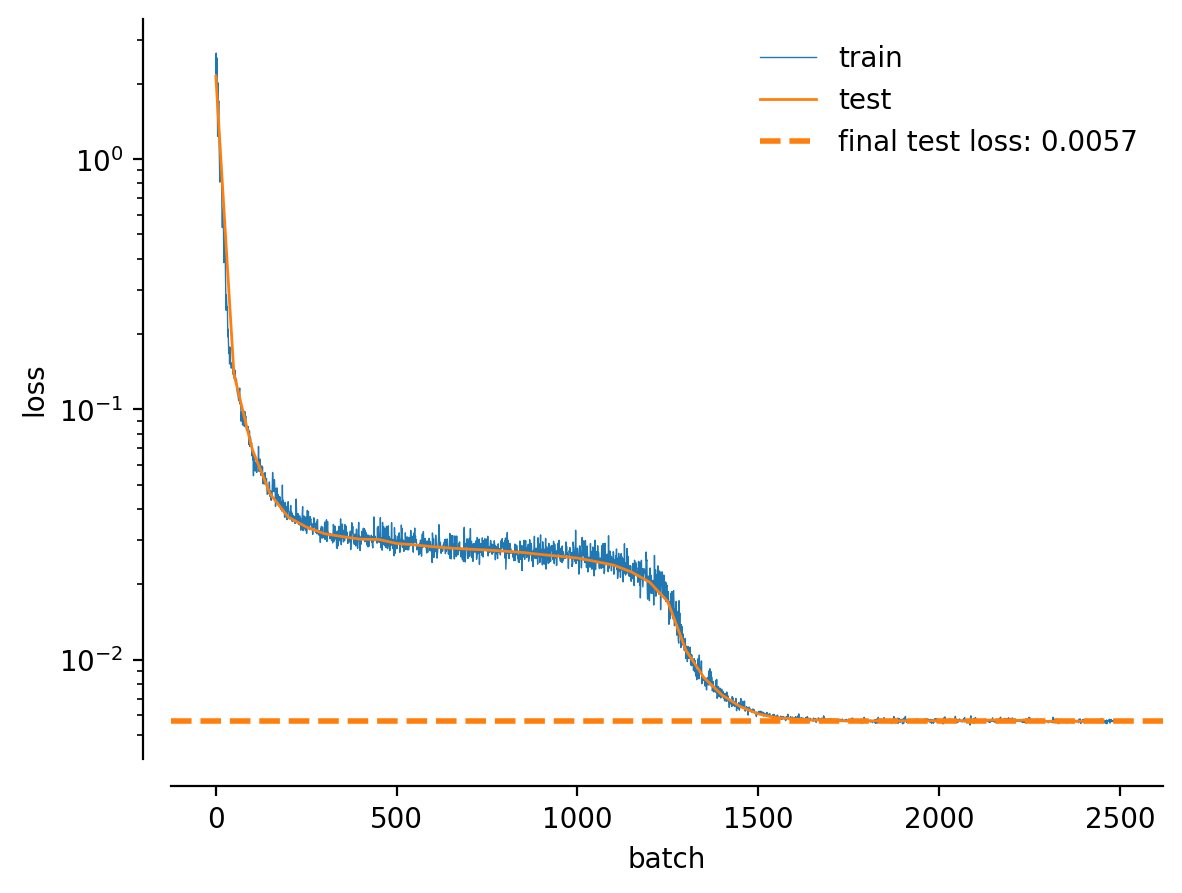

In [56]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

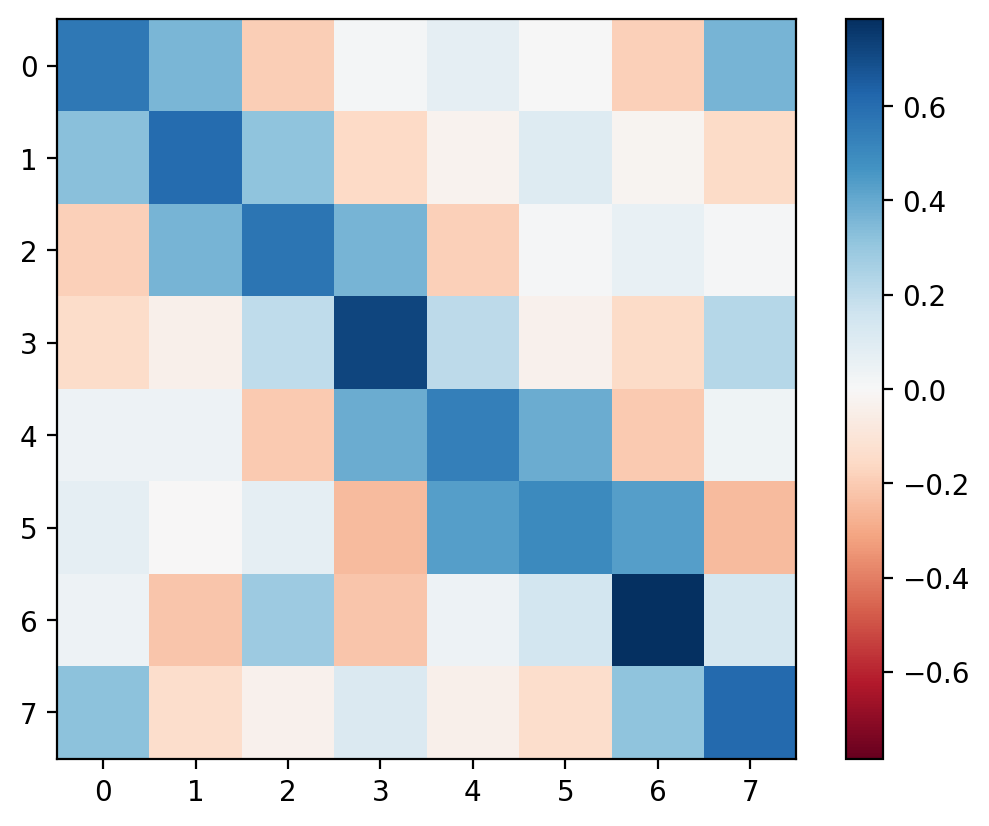

In [57]:
crt_tensor = torch.real(system.V @ system.U).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

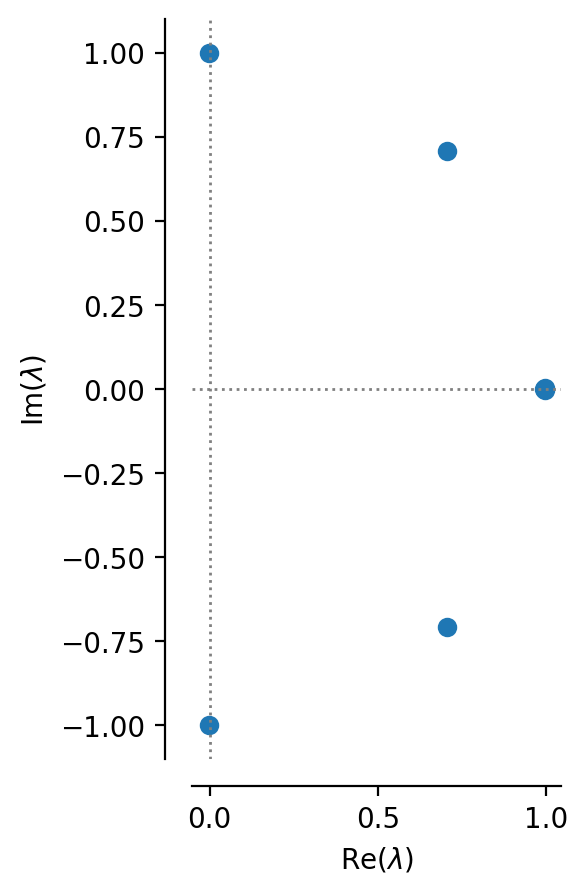

In [58]:
fig, ax = plt.subplots()
crt_v = system.lbd.detach().numpy()

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [59]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.7075, grad_fn=<MaxBackward1>),
 tensor(1.8266, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [60]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [61]:
test_moved = system.propagate_place(test_trajectory, 1 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

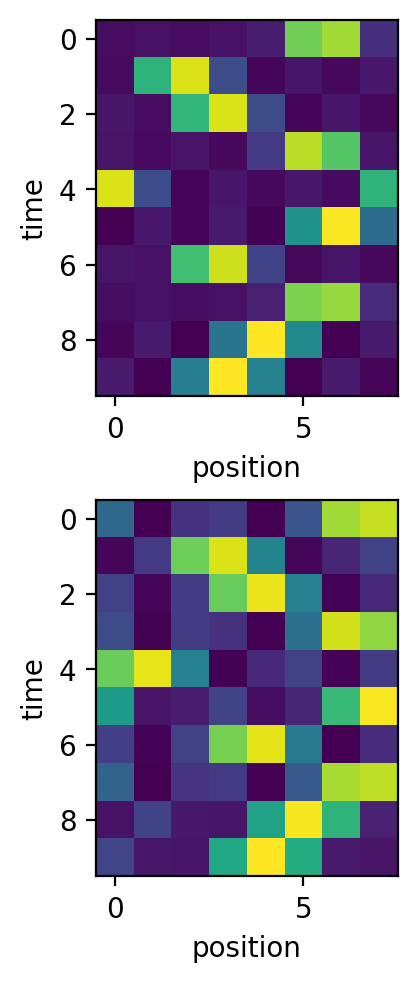

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [63]:
[torch.min(torch.abs(system.lbd)), torch.max(torch.abs(system.lbd))]

[tensor(0.9937, grad_fn=<MinBackward1>),
 tensor(0.9994, grad_fn=<MaxBackward1>)]

Text(0.5, 0, 'Im')

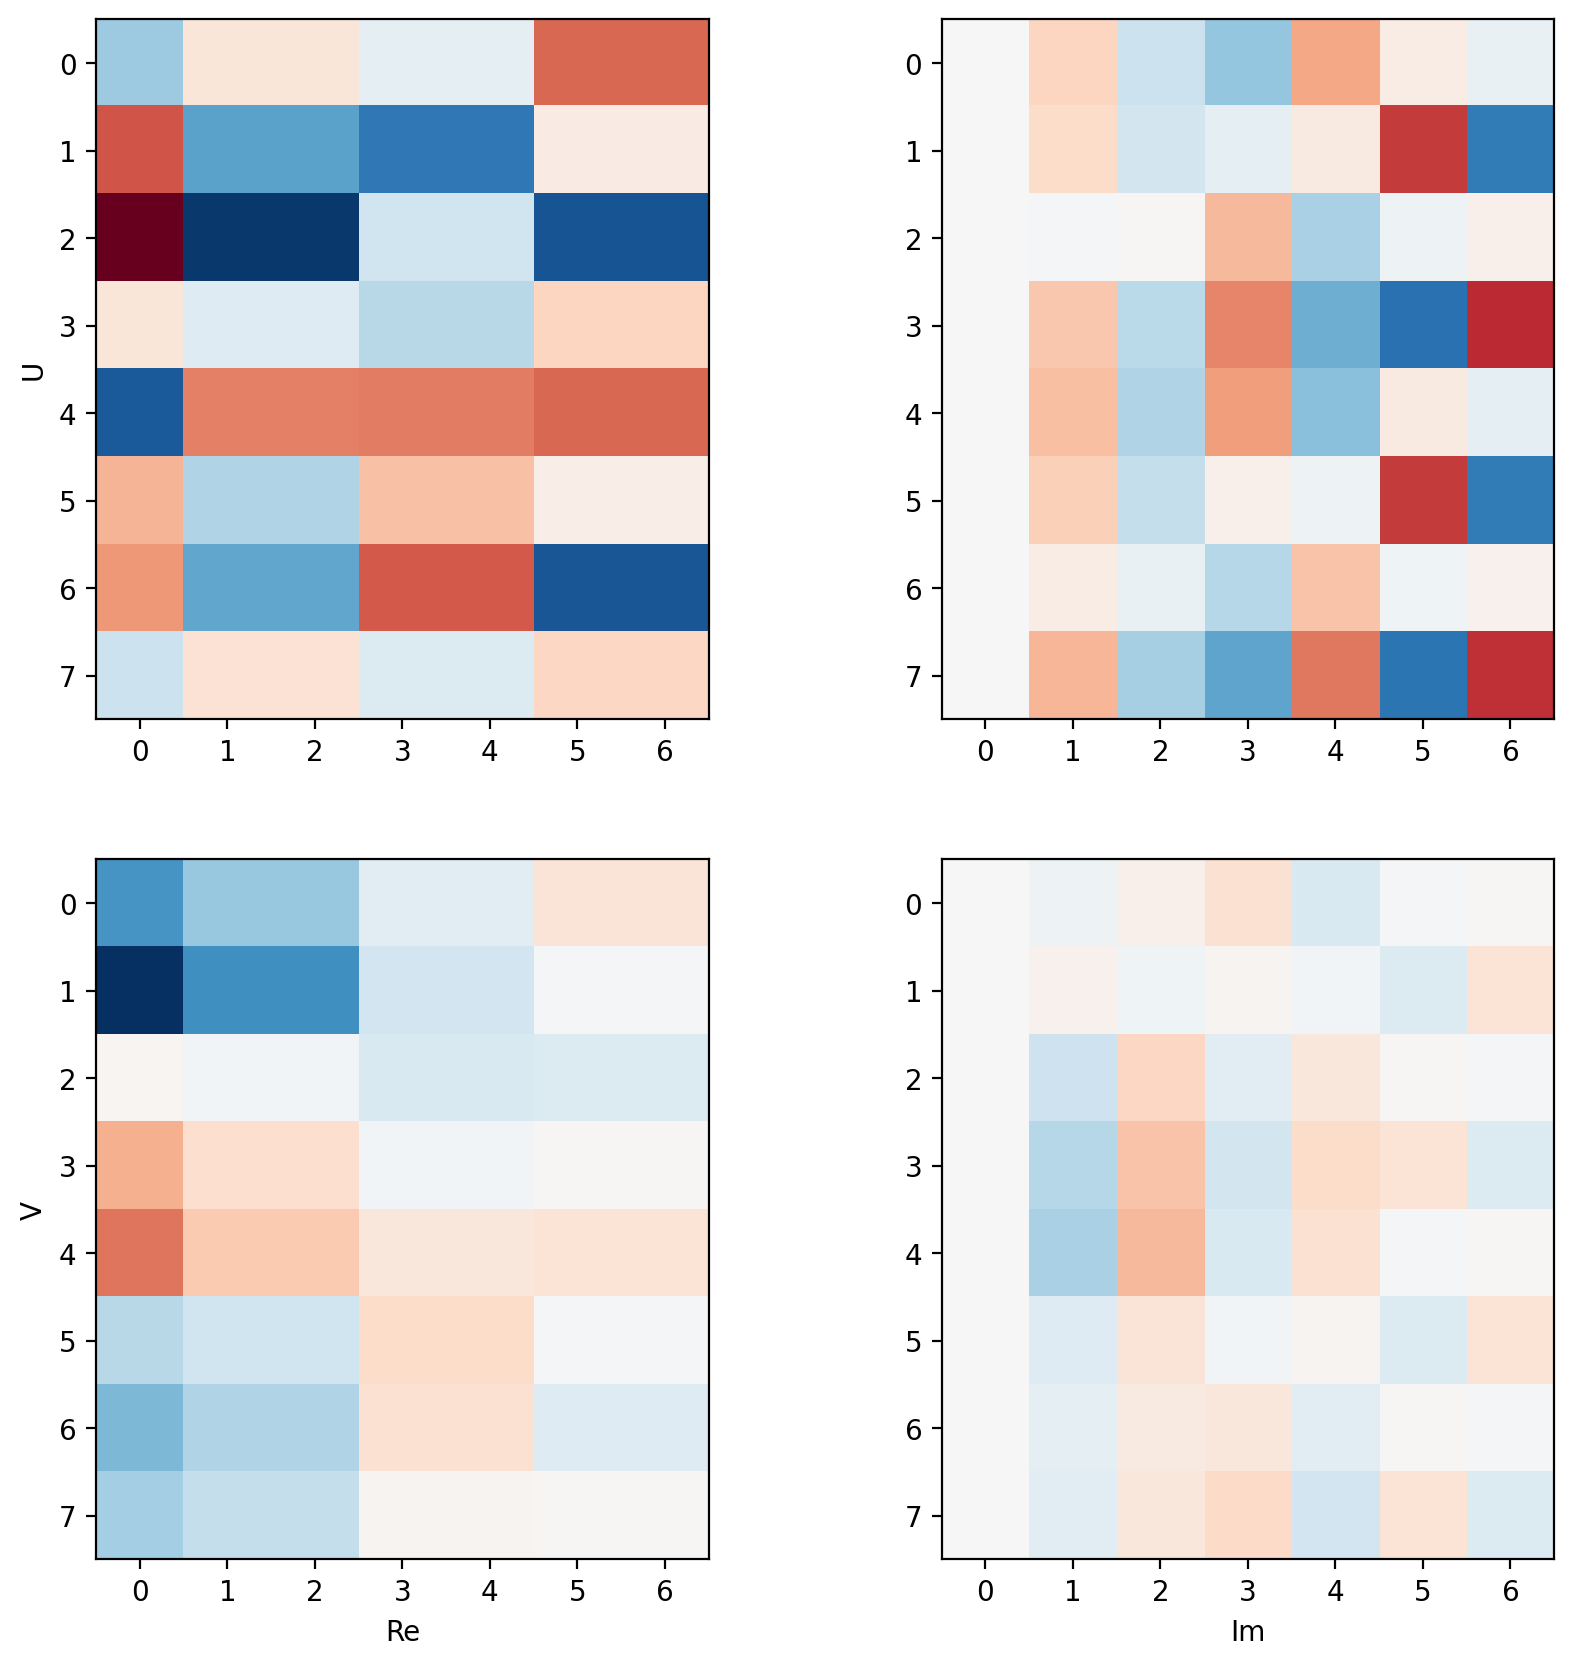

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
crt_d = {"U": system.U.T, "V": system.V}
crt_ordering = np.argsort(np.abs(np.angle(system.lbd.detach().numpy())))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))

    ax_row = axs[i]
    ax_row[0].imshow(crt_mat.real, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")
    ax_row[1].imshow(crt_mat.imag, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax_row[0].set_ylabel(crt_name)

axs[1, 0].set_xlabel("Re")
axs[1, 1].set_xlabel("Im")

### Real-valued simulation

In [65]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(
#     optimizer,
#     [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
# )
scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 498999/498999 [02:59<00:00, 2775.15it/s, train batch loss: 0.000000]


In [66]:
# scheduler.get_last_lr()

In [67]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.xi - original_xi)),
    torch.median(torch.abs(system.theta - original_theta)),
)

(tensor(0.3315, grad_fn=<MedianBackward0>),
 tensor(0.3162, grad_fn=<MedianBackward0>),
 tensor(0.0768, grad_fn=<MedianBackward0>),
 tensor(1.5152, grad_fn=<MedianBackward0>))

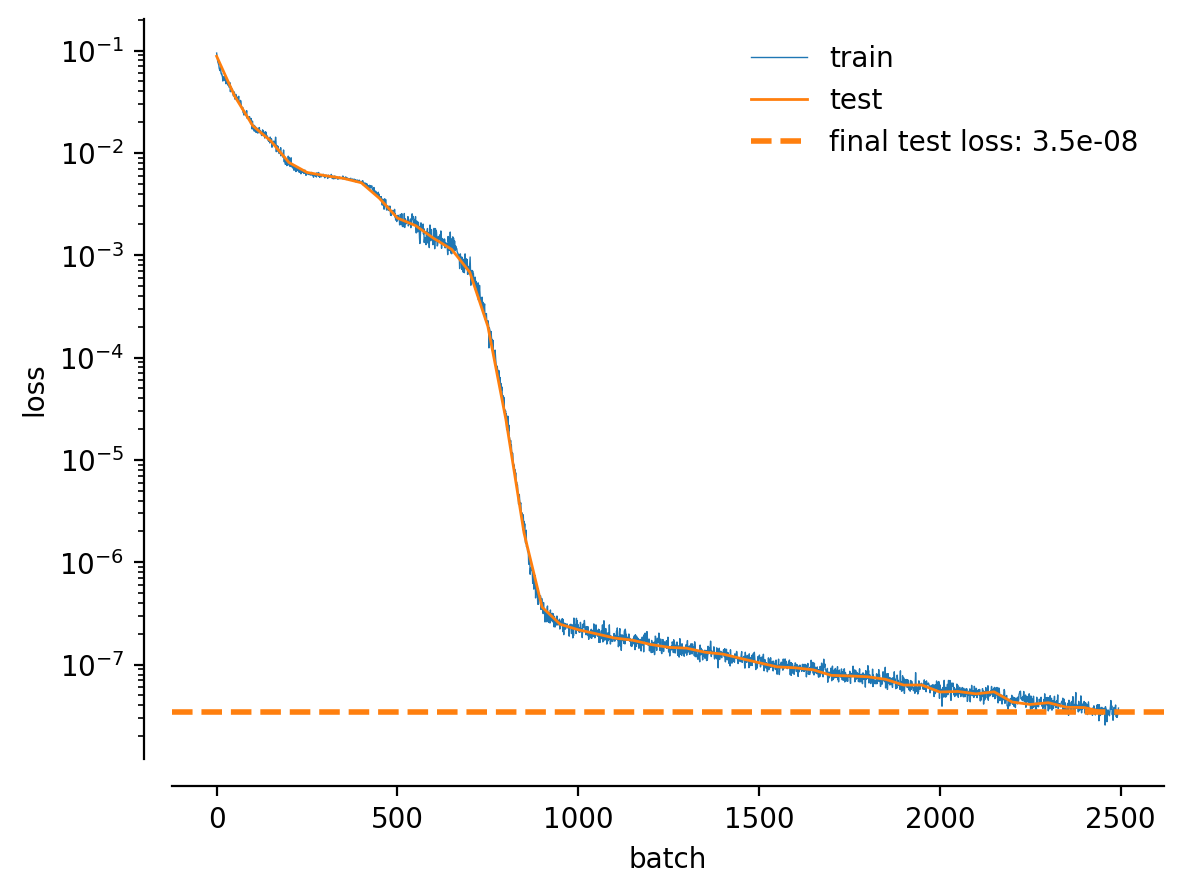

In [68]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

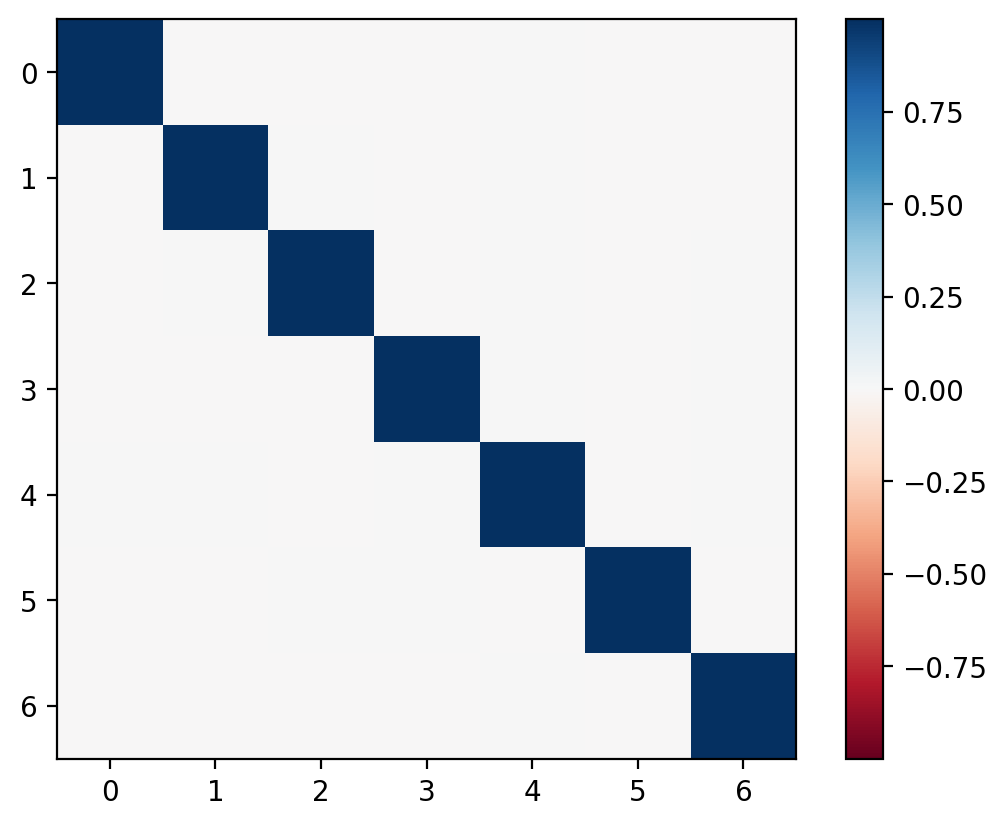

In [69]:
crt_tensor = (system.U @ system.V).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

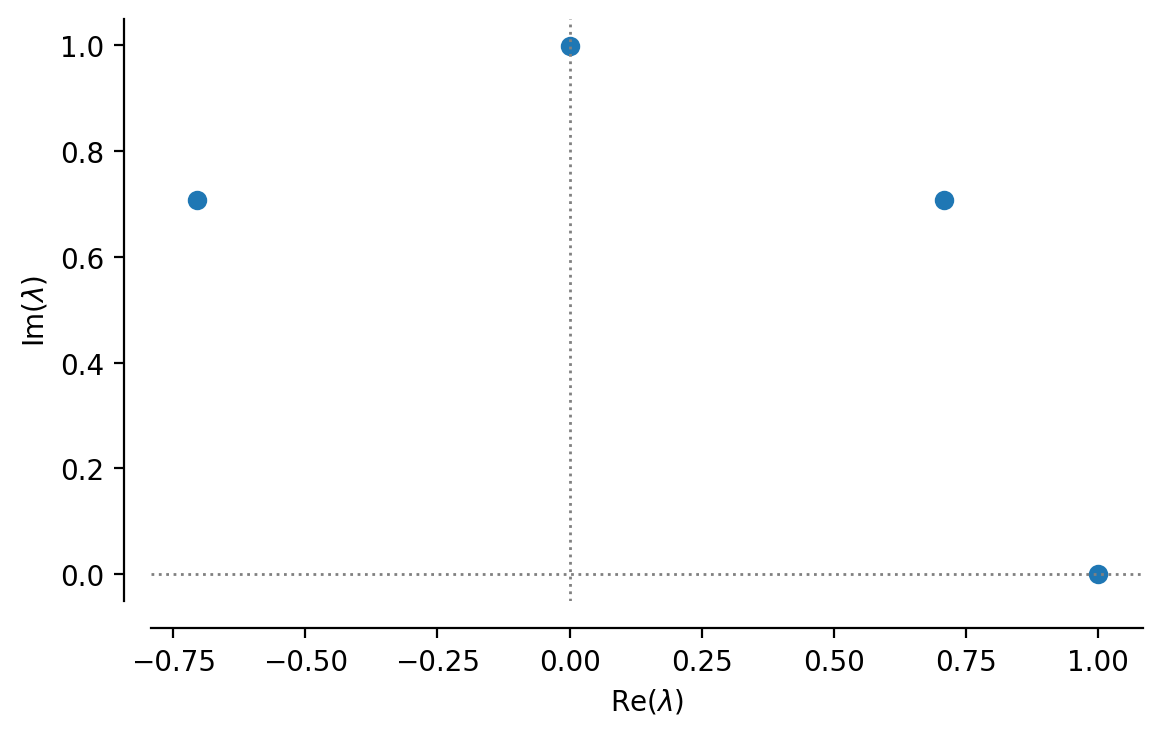

In [70]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [71]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.6442, grad_fn=<MaxBackward1>),
 tensor(0.5261, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [72]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [73]:
test_moved = system.propagate_place(test_trajectory, 1 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

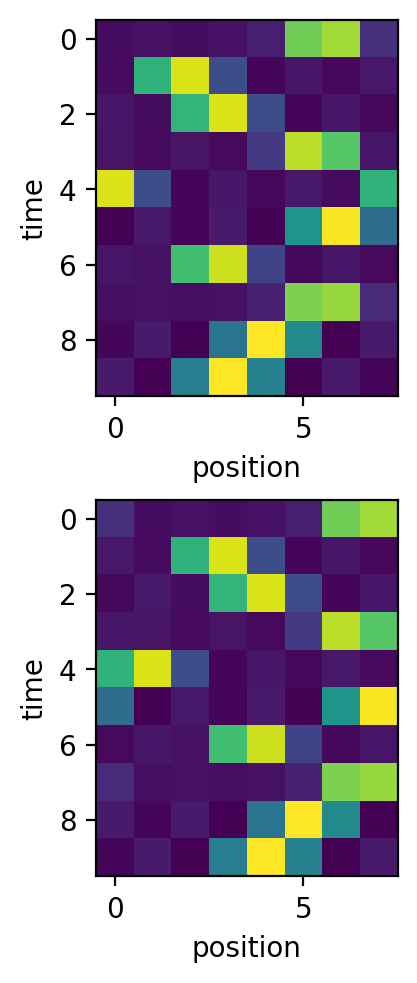

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [75]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(1.5216e-09, grad_fn=<MinBackward1>),
 tensor(0.0099, grad_fn=<MaxBackward1>)]

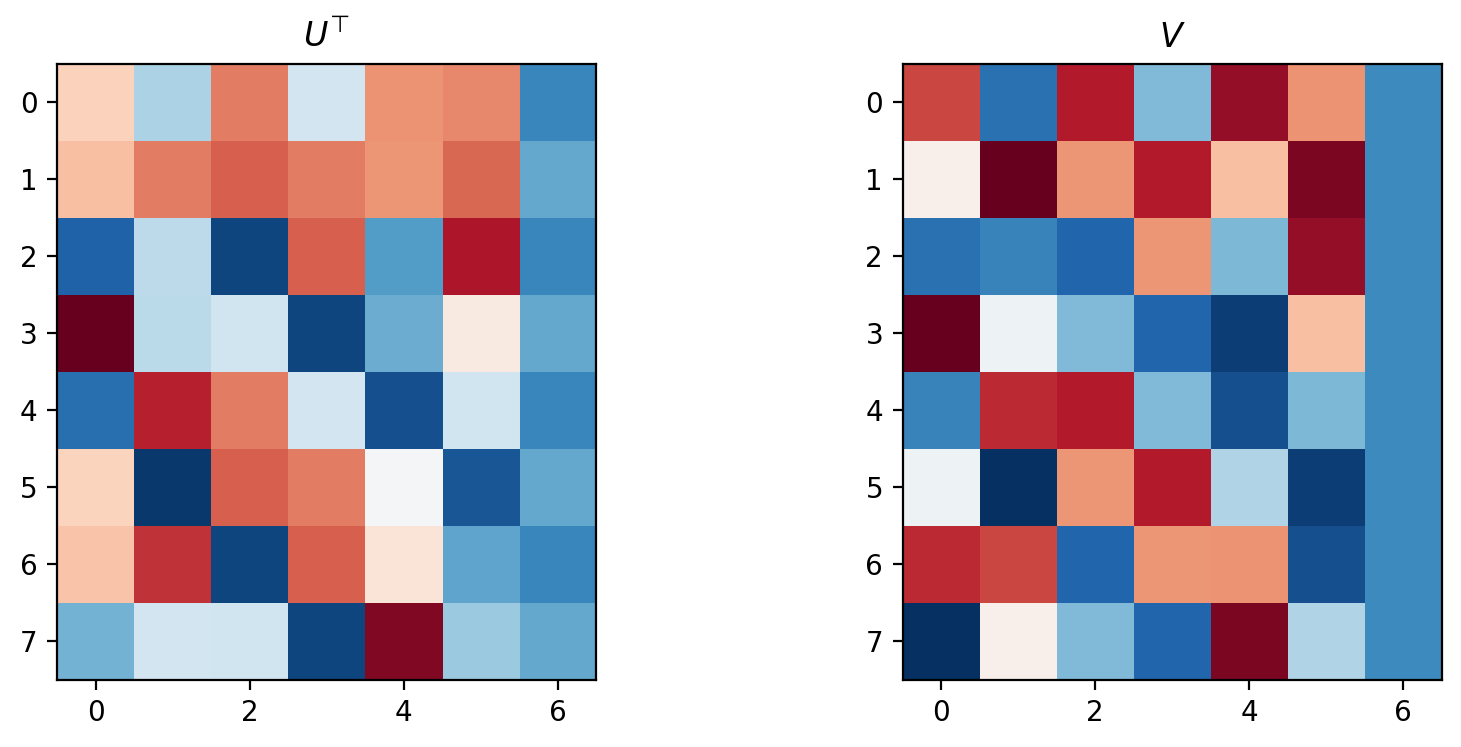

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

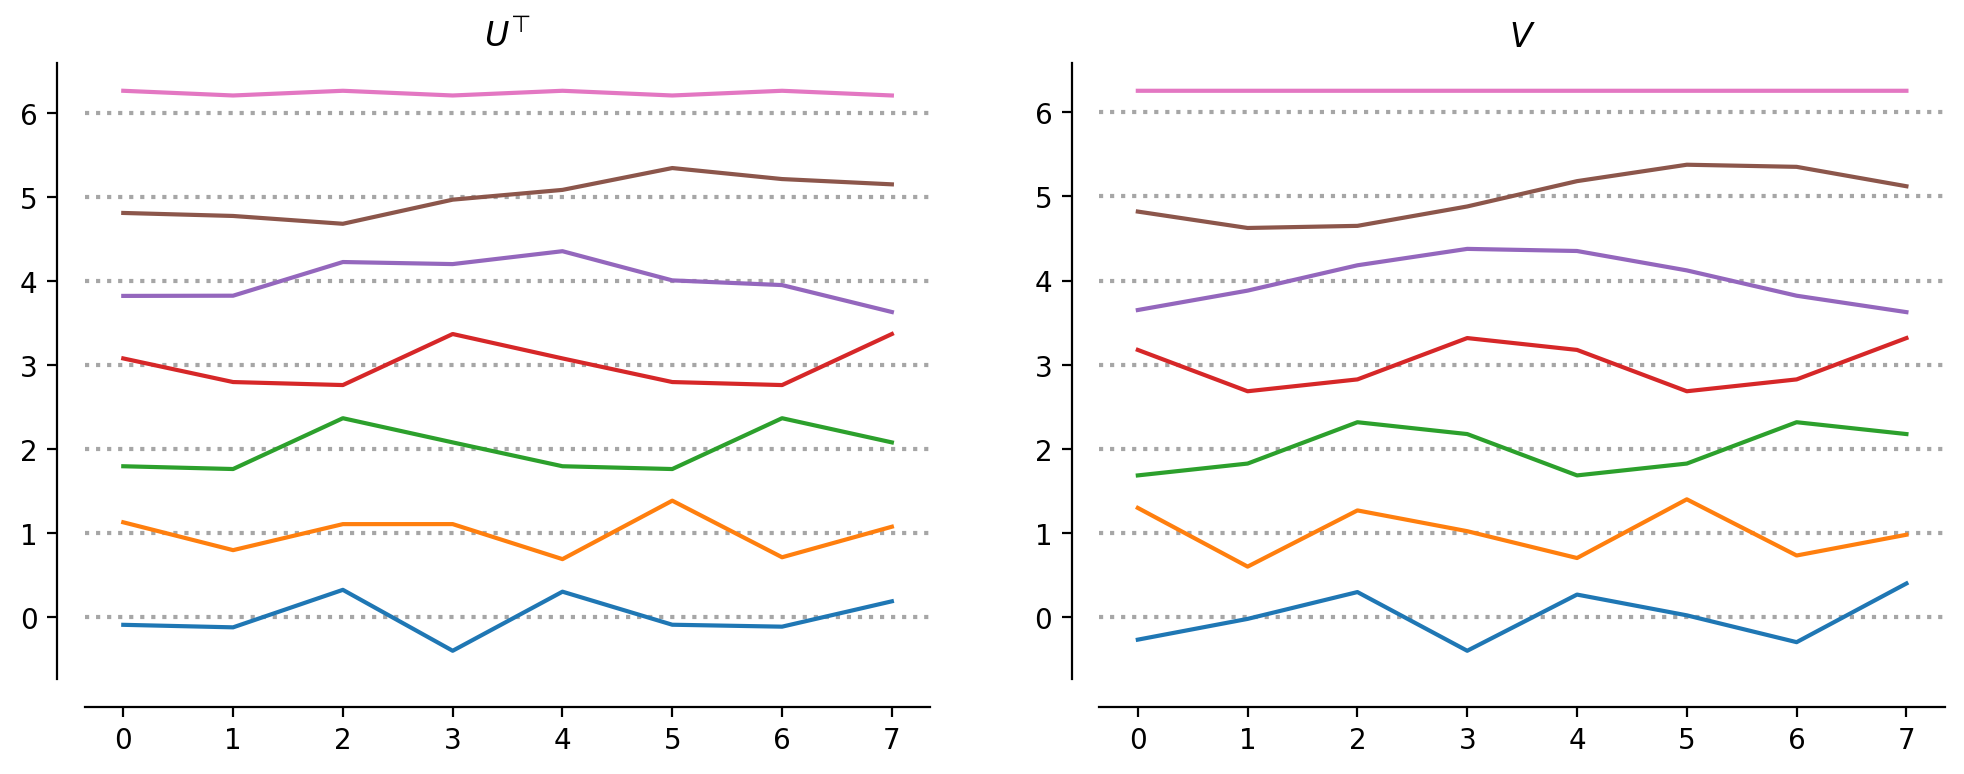

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
for i, crt_name in enumerate(crt_d):
    ax = axs[i]
    crt_mat = crt_d[crt_name].detach().numpy()
    crt_lim = np.max(np.abs(crt_mat))
    for k in range(m):
        crt_v = crt_mat[:, k]
        ax.axhline(k, ls=":", c="gray", alpha=0.7)
        ax.plot(np.arange(n), k + 0.4 * crt_v / crt_lim)
    
    ax.set_title(crt_name)
    sns.despine(ax=ax, offset=10)

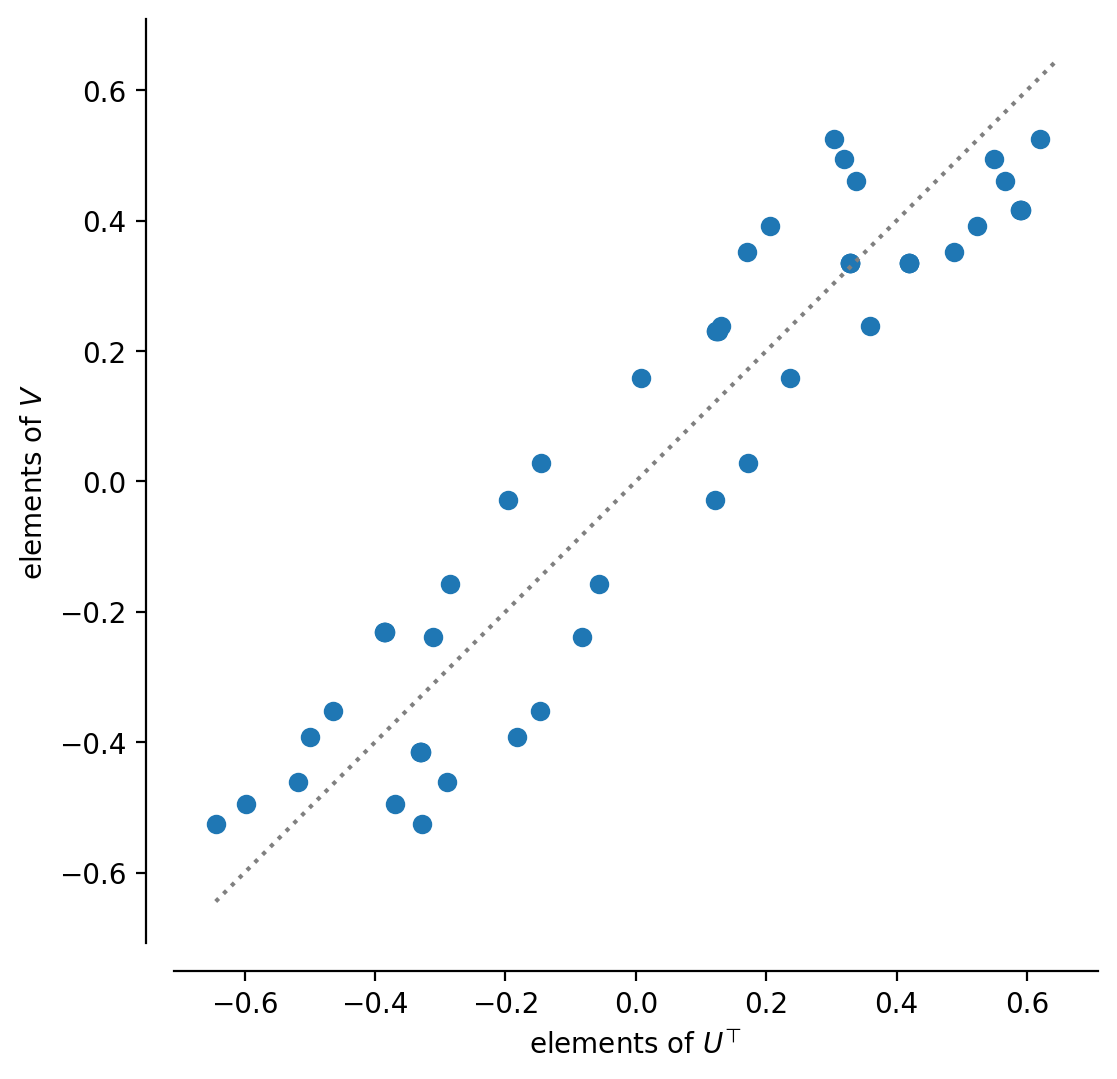

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))
crt_u = system.U.T.detach().numpy()
crt_vt = system.V.detach().numpy()
crt_lim = max(np.max(np.abs(_)) for _ in [crt_u, crt_vt])
ax.plot([-crt_lim, crt_lim], [-crt_lim, crt_lim], c="gray", ls=":")
ax.scatter(crt_u, crt_vt)
ax.set_xlabel("elements of $U^\\top$")
ax.set_ylabel("elements of $V$")

ax.set_aspect(1)
sns.despine(ax=ax, offset=10)

## Test learning with non-Fourier bump movements

In [79]:
torch.manual_seed(0)

n = 8
simulator = PlaceGridMotionSimulator(n, sigma=0.5, fourier=False)

n_samples = 500_000
s = torch.normal(torch.zeros(n_samples), 1.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 1000
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

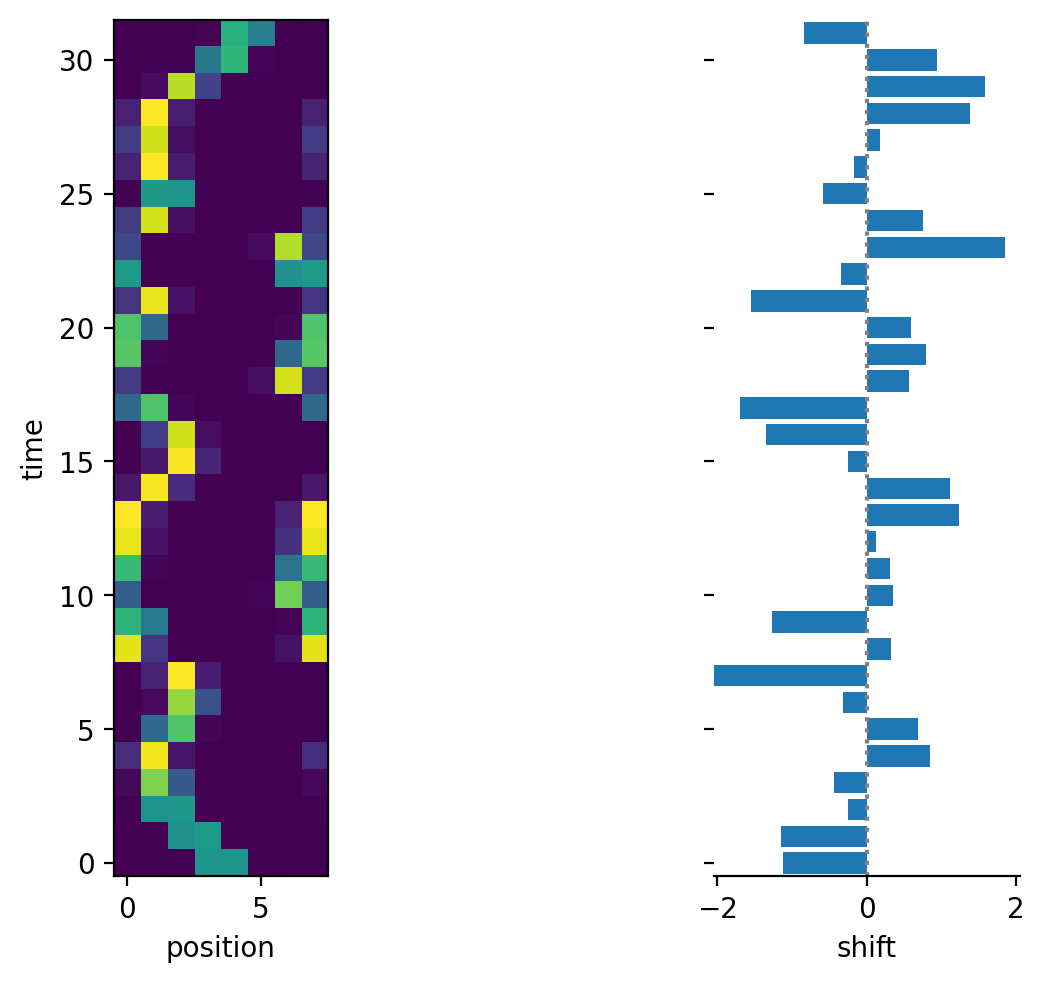

In [80]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

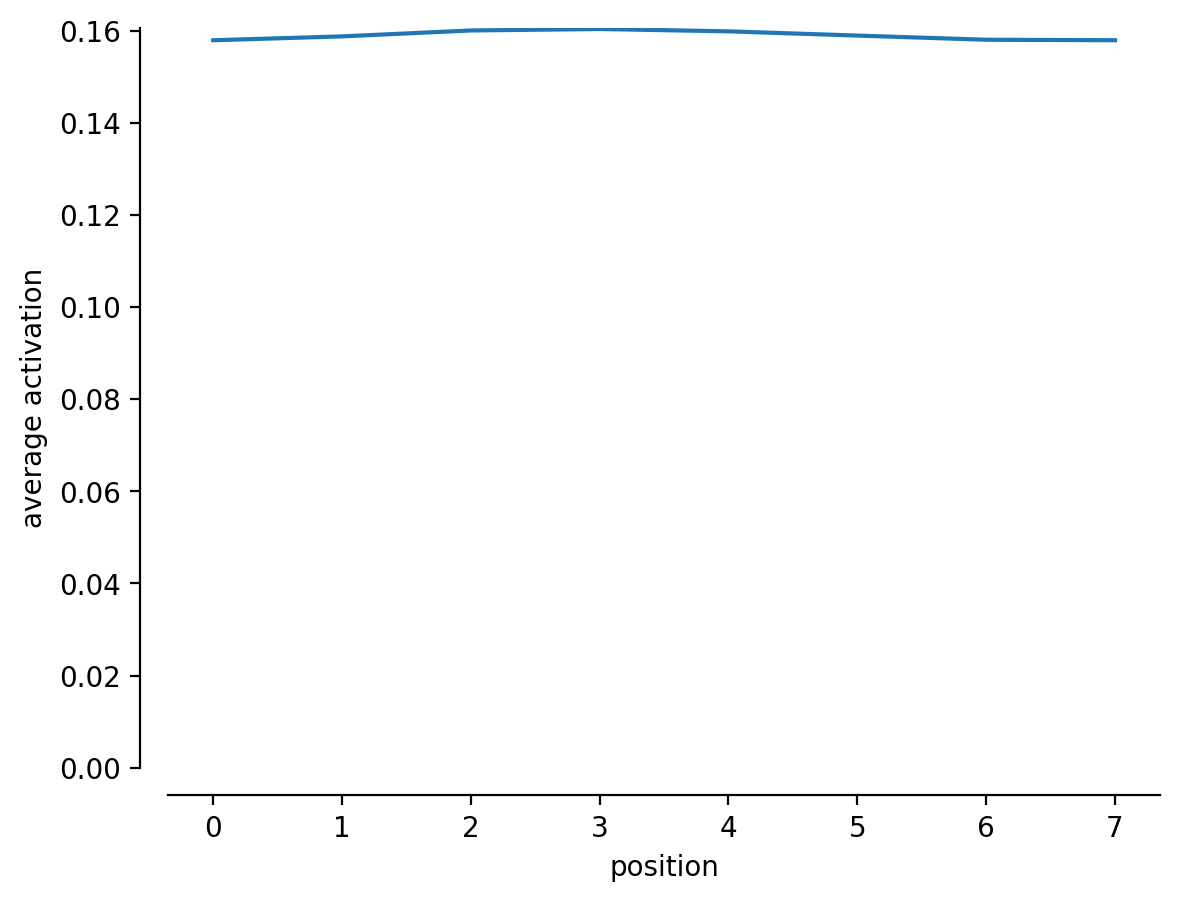

In [81]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Real-valued simulation

In [82]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(
#     optimizer,
#     [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
# )
scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 498999/498999 [03:00<00:00, 2760.24it/s, train batch loss: 0.004644]


In [83]:
# scheduler.get_last_lr()

In [84]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.xi - original_xi)),
    torch.median(torch.abs(system.theta - original_theta)),
)

(tensor(0.3115, grad_fn=<MedianBackward0>),
 tensor(0.3842, grad_fn=<MedianBackward0>),
 tensor(0.0768, grad_fn=<MedianBackward0>),
 tensor(1.5503, grad_fn=<MedianBackward0>))

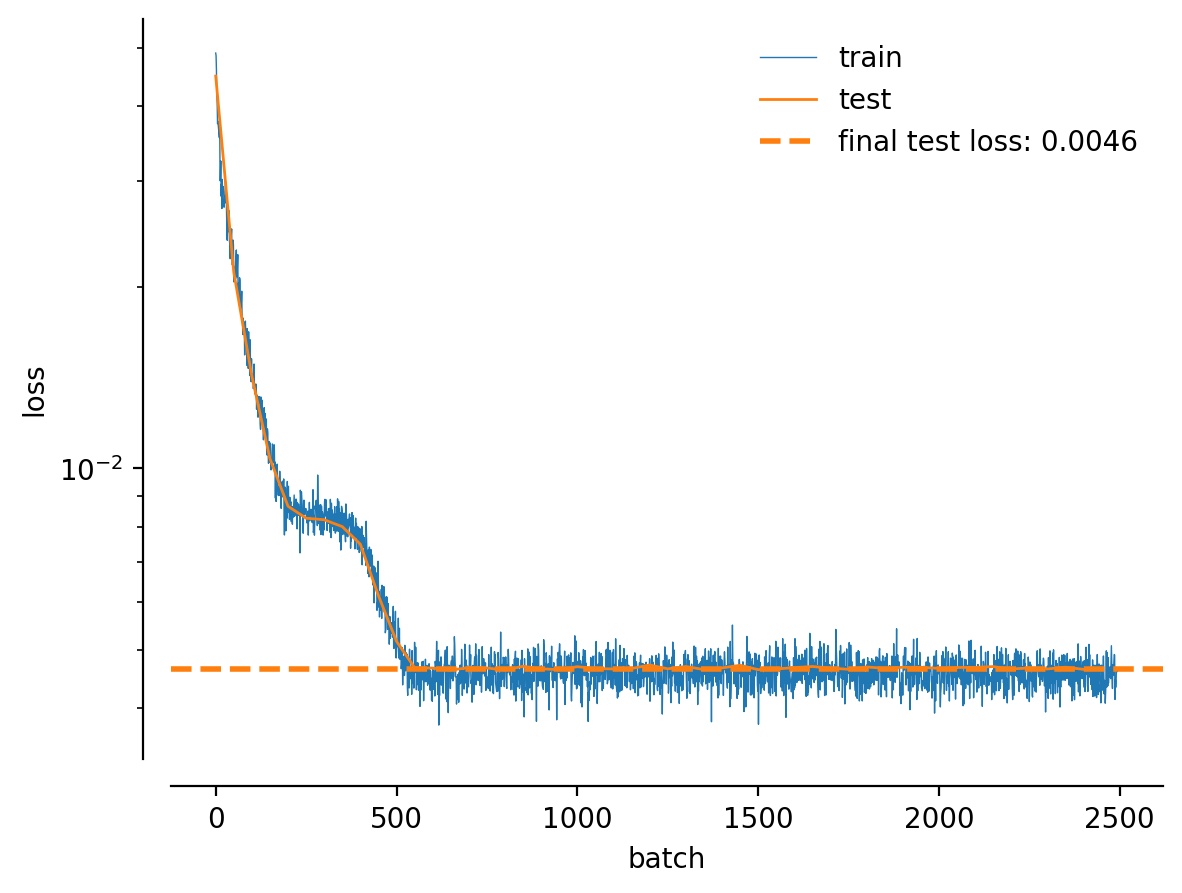

In [85]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

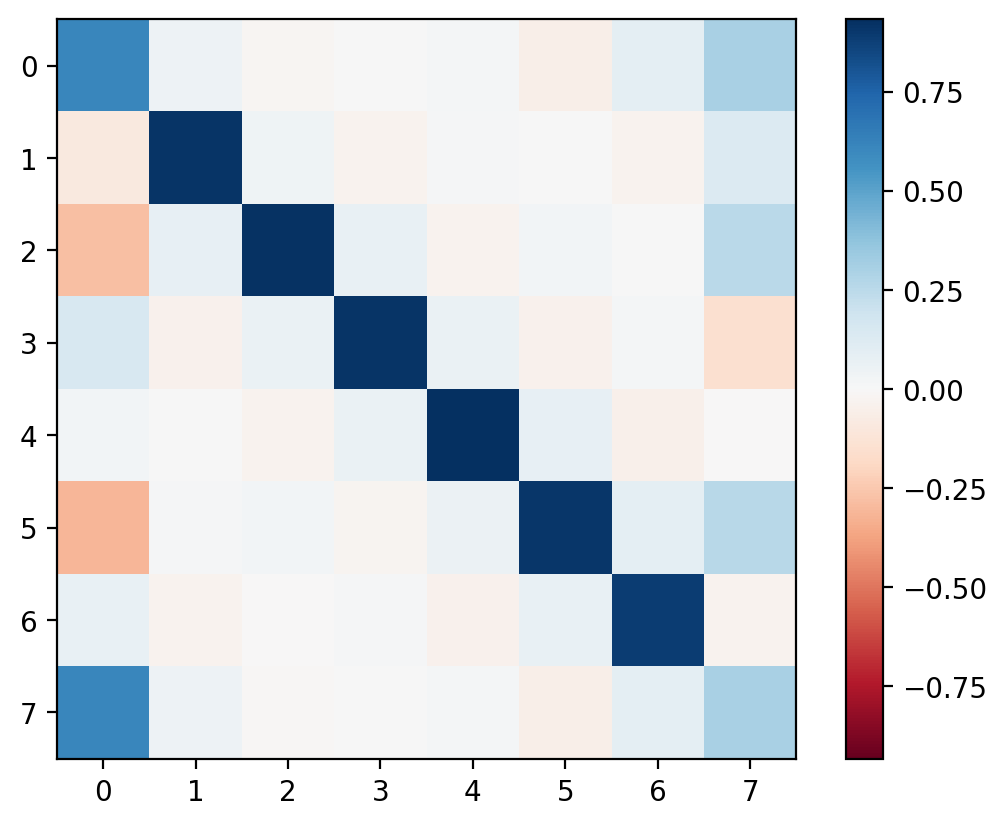

In [86]:
crt_tensor = (system.V @ system.U).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

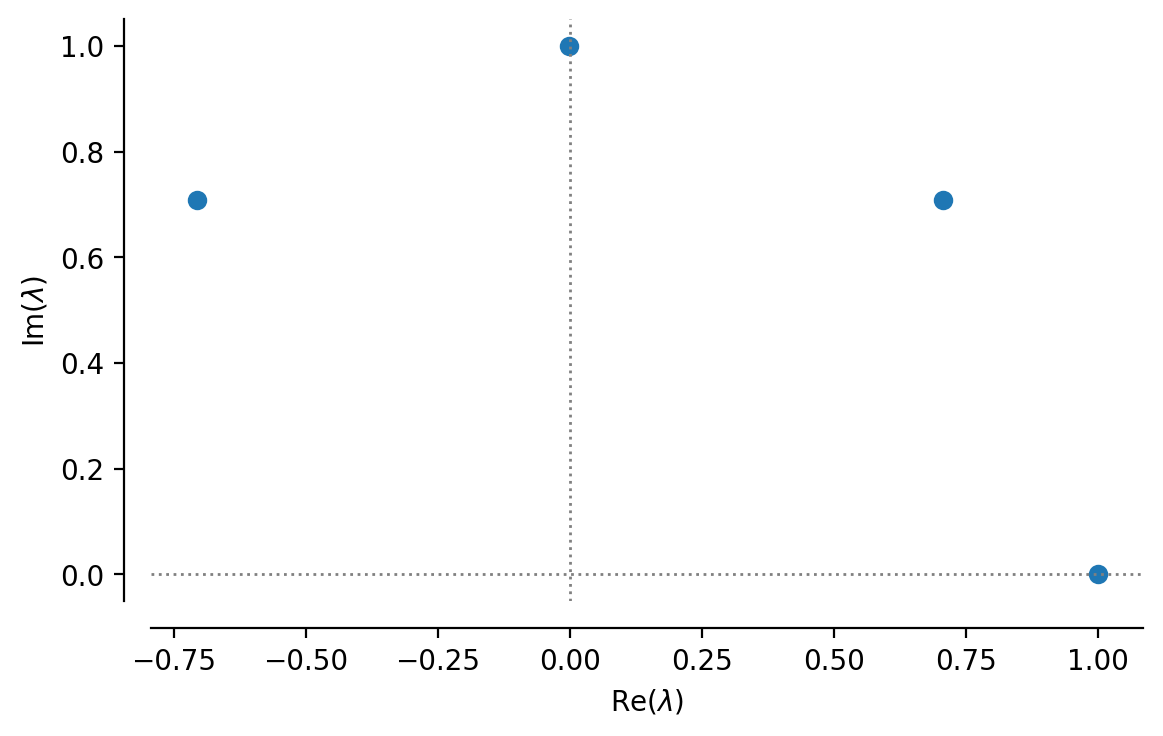

In [87]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [88]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.6604, grad_fn=<MaxBackward1>),
 tensor(0.5527, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [89]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [90]:
test_moved = system.propagate_place(test_trajectory, 1 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

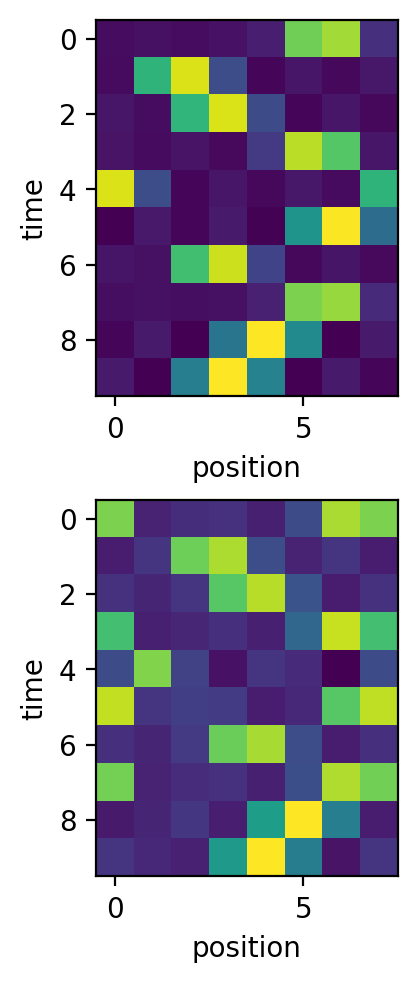

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [92]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(4.9177e-19, grad_fn=<MinBackward1>),
 tensor(5.9910e-07, grad_fn=<MaxBackward1>)]

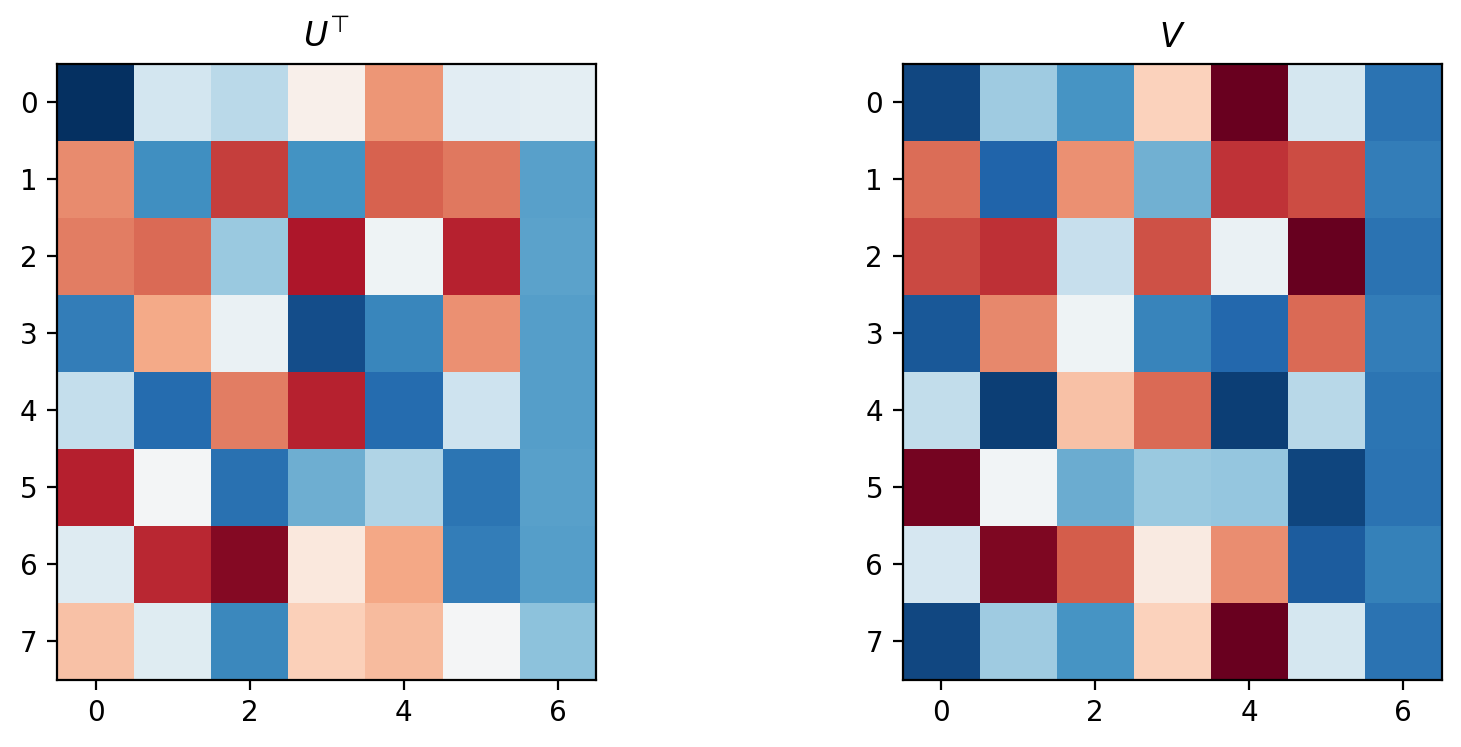

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

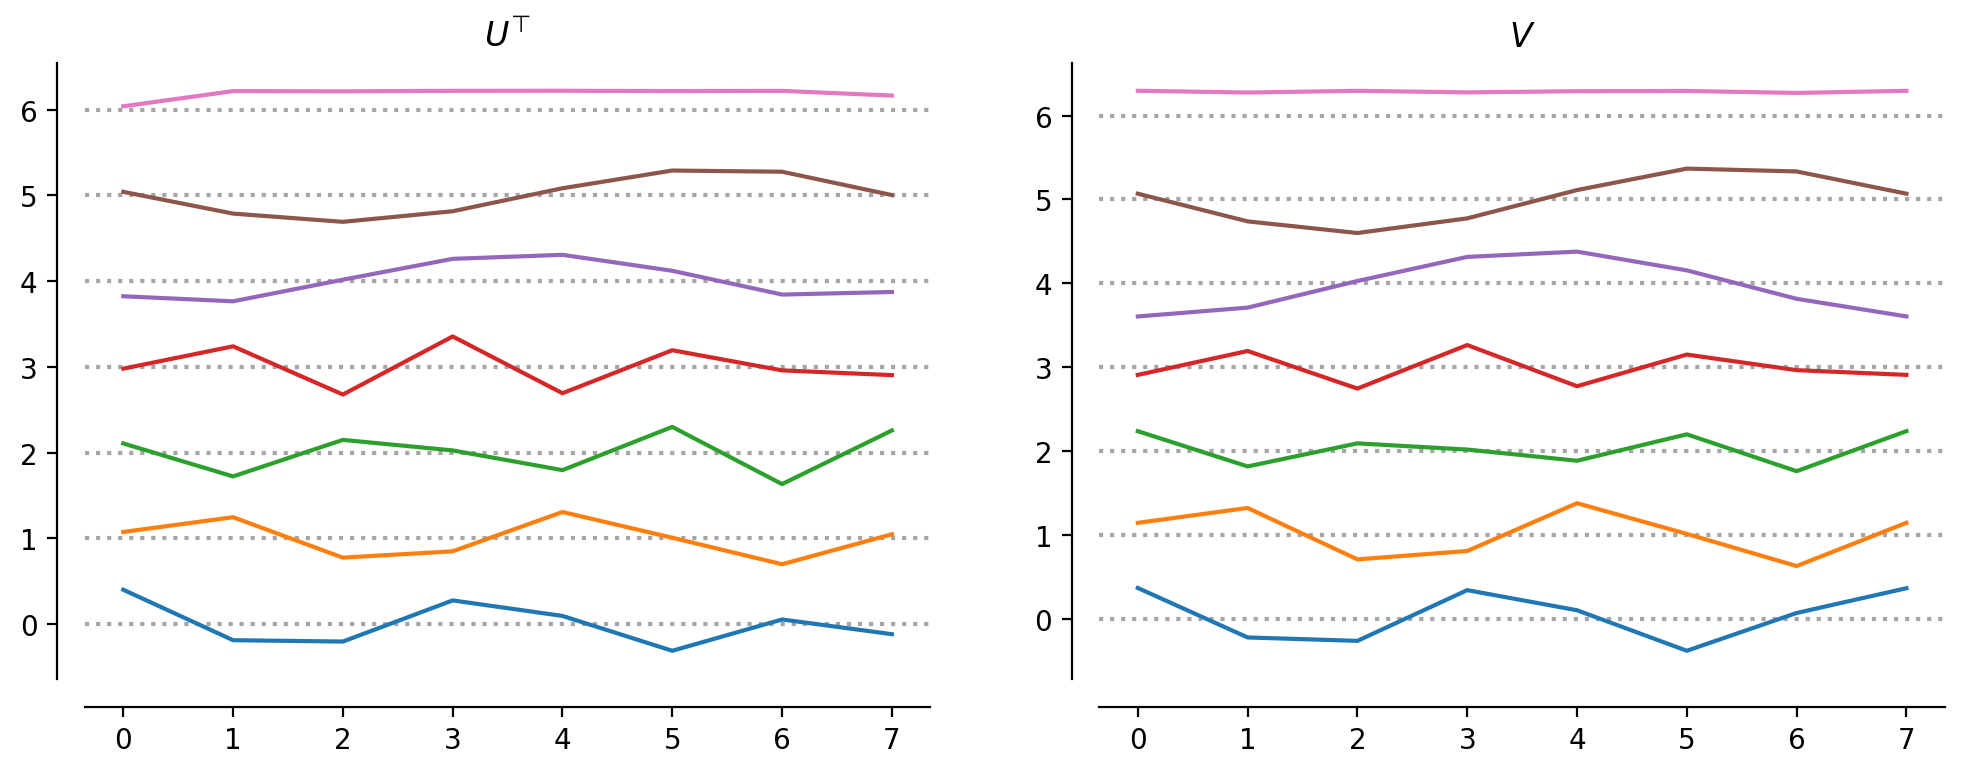

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
for i, crt_name in enumerate(crt_d):
    ax = axs[i]
    crt_mat = crt_d[crt_name].detach().numpy()
    crt_lim = np.max(np.abs(crt_mat))
    for k in range(m):
        crt_v = crt_mat[:, k]
        ax.axhline(k, ls=":", c="gray", alpha=0.7)
        ax.plot(np.arange(n), k + 0.4 * crt_v / crt_lim)
    
    ax.set_title(crt_name)
    sns.despine(ax=ax, offset=10)

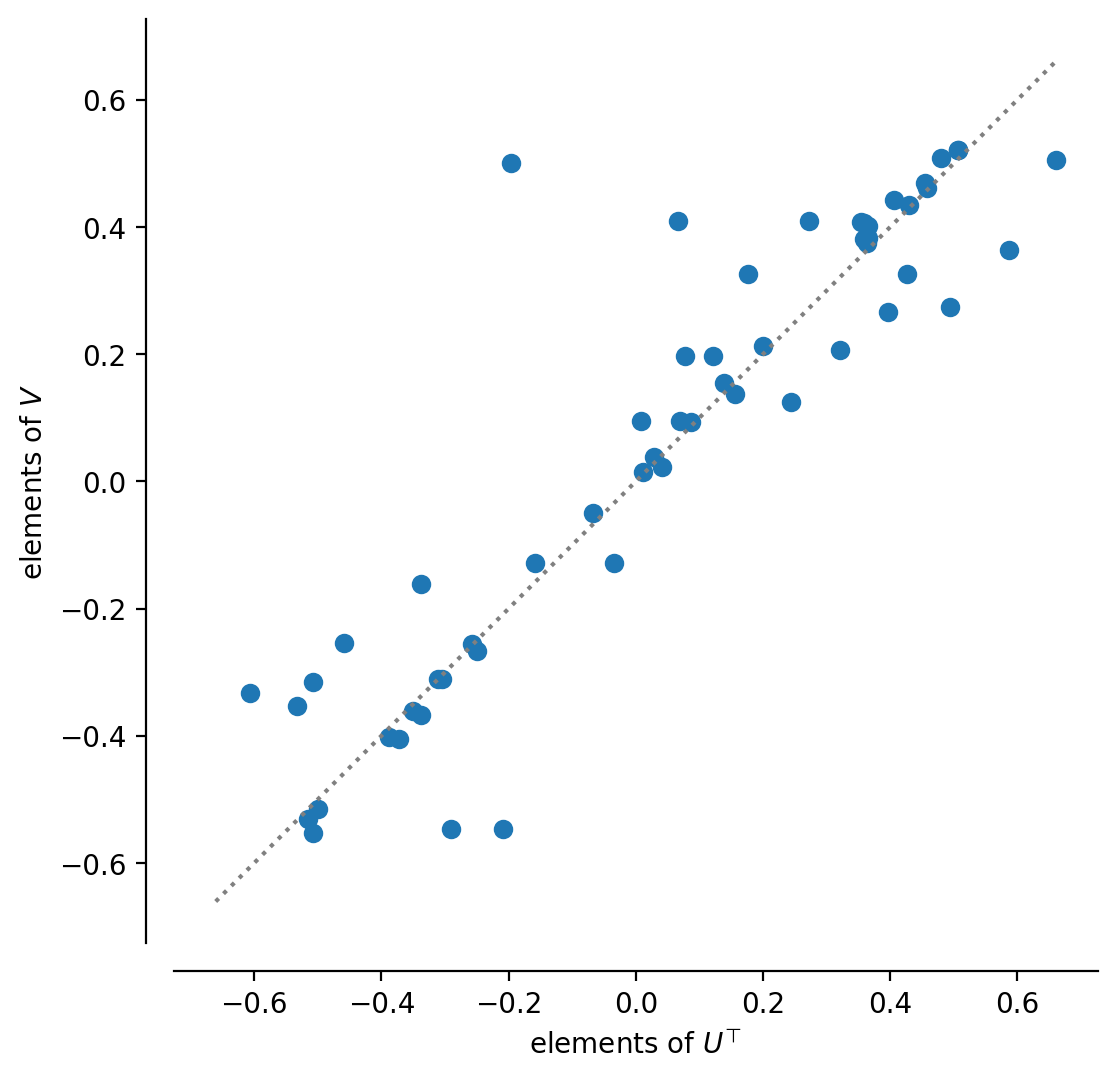

In [95]:
fig, ax = plt.subplots(figsize=(6, 6))
crt_u = system.U.T.detach().numpy()
crt_vt = system.V.detach().numpy()
crt_lim = max(np.max(np.abs(_)) for _ in [crt_u, crt_vt])
ax.plot([-crt_lim, crt_lim], [-crt_lim, crt_lim], c="gray", ls=":")
ax.scatter(crt_u, crt_vt)
ax.set_xlabel("elements of $U^\\top$")
ax.set_ylabel("elements of $V$")

ax.set_aspect(1)
sns.despine(ax=ax, offset=10)

## Test learning with non-periodic bump movements

In [96]:
torch.manual_seed(0)

n = 8
simulator = PlaceGridMotionSimulator(n, sigma=0.5, fourier=False, periodic=False)

n_samples = 500_000
s = torch.normal(torch.zeros(n_samples), 1.0)
trajectory = simulator.batch(s)

dataset_full = [(trajectory[i], trajectory[i + 1], s[i]) for i in range(n_samples - 1)]

test_size = 1000
dataset_train = dataset_full[:-test_size]
dataset_test = dataset_full[-test_size:]

batch_size = 200
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

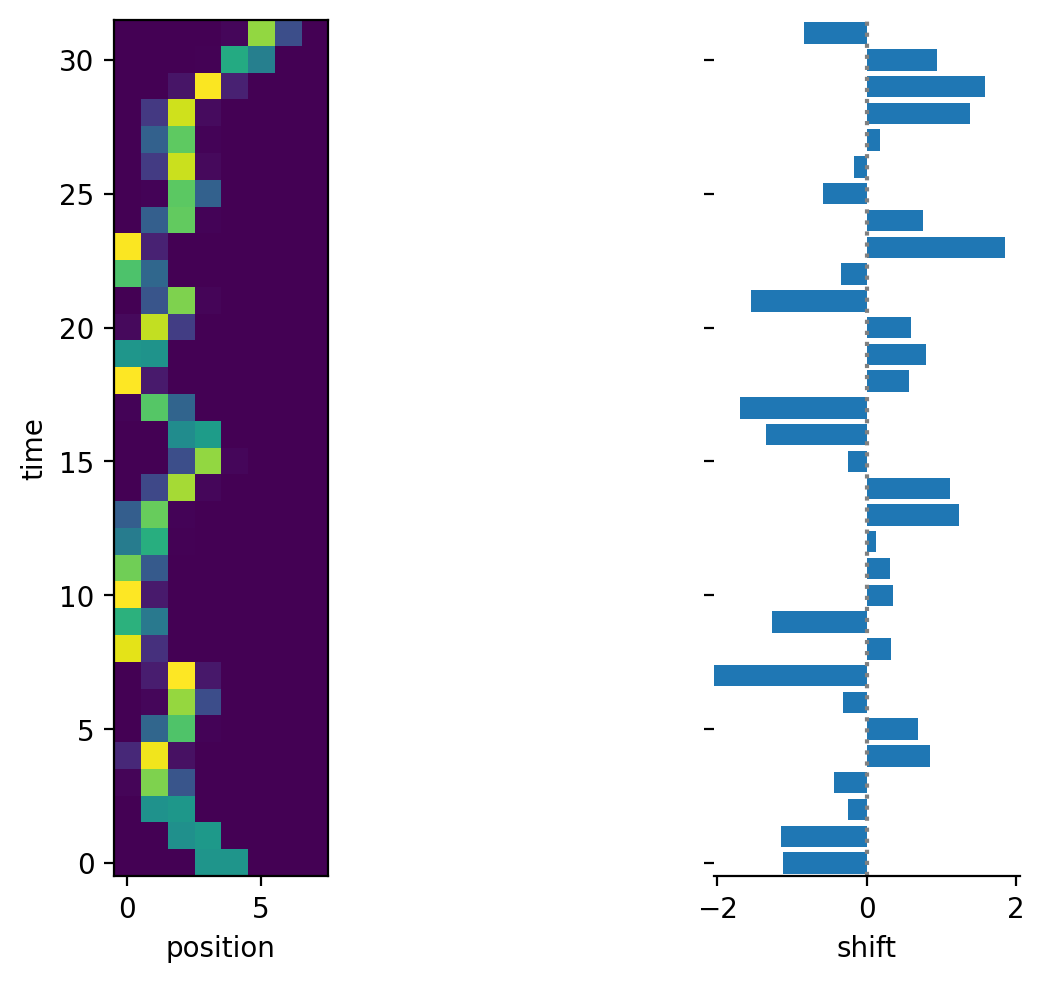

In [97]:
crt_n = 4 * n
crt_step = 1

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, constrained_layout=True, gridspec_kw={"width_ratios": (3, 1)}
)
ax1.imshow(trajectory[:crt_n:crt_step])
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.barh(width=s[:crt_n:crt_step], y=np.arange(0, crt_n // crt_step))
ax2.axvline(0, ls=":", c="gray")
crt_xl = max(ax2.get_xlim())
ax2.set_xlim(-crt_xl, crt_xl)
ax2.set_ylim(ax1.get_ylim())
ax2.invert_yaxis()
ax2.set_xlabel("shift")
sns.despine(ax=ax2, left=True)

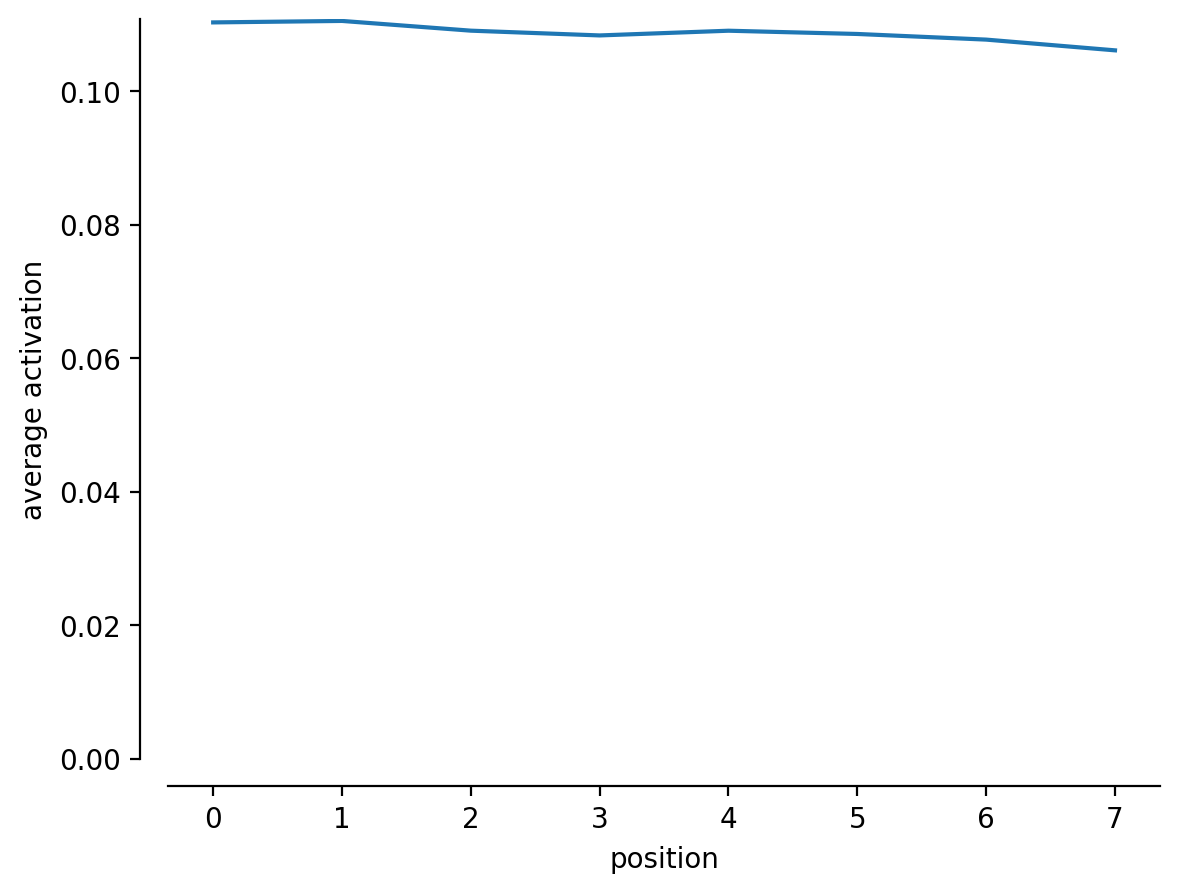

In [98]:
fig, ax = plt.subplots()
ax.plot(torch.mean(trajectory, dim=0))
ax.set_ylim(0, None)

ax.set_xlabel("position")
ax.set_ylabel("average activation")
sns.despine(ax=ax, offset=10)

### Real-valued simulation

In [99]:
torch.manual_seed(0)

m = n - 1

system = PlaceGridSystemNonBio(n, m)

original_U = torch.clone(system.U).detach()
original_V = torch.clone(system.V).detach()
original_xi = torch.clone(system.xi).detach()
original_theta = torch.clone(system.theta).detach()

optimizer = torch.optim.AdamW(system.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)
# scheduler = StepwiseScheduler(
#     optimizer,
#     [(100, 0.01), (100, 0.05), (100, 0.03), (300, 0.02), (1600, 0.01), (100, 0.005)]
# )
scheduler = None
train_results = train(
    system,
    "cpu",
    dataloader_train,
    optimizer,
    test_set=dataloader_test,
    test_every=50,
    scheduler=scheduler,
)

100%|██████████| 498999/498999 [03:01<00:00, 2748.93it/s, train batch loss: 0.004249]


In [100]:
# scheduler.get_last_lr()

In [101]:
(
    torch.median(torch.abs(system.U - original_U)),
    torch.median(torch.abs(system.V - original_V)),
    torch.median(torch.abs(system.xi - original_xi)),
    torch.median(torch.abs(system.theta - original_theta)),
)

(tensor(0.3445, grad_fn=<MedianBackward0>),
 tensor(0.2985, grad_fn=<MedianBackward0>),
 tensor(0.0768, grad_fn=<MedianBackward0>),
 tensor(1.0502, grad_fn=<MedianBackward0>))

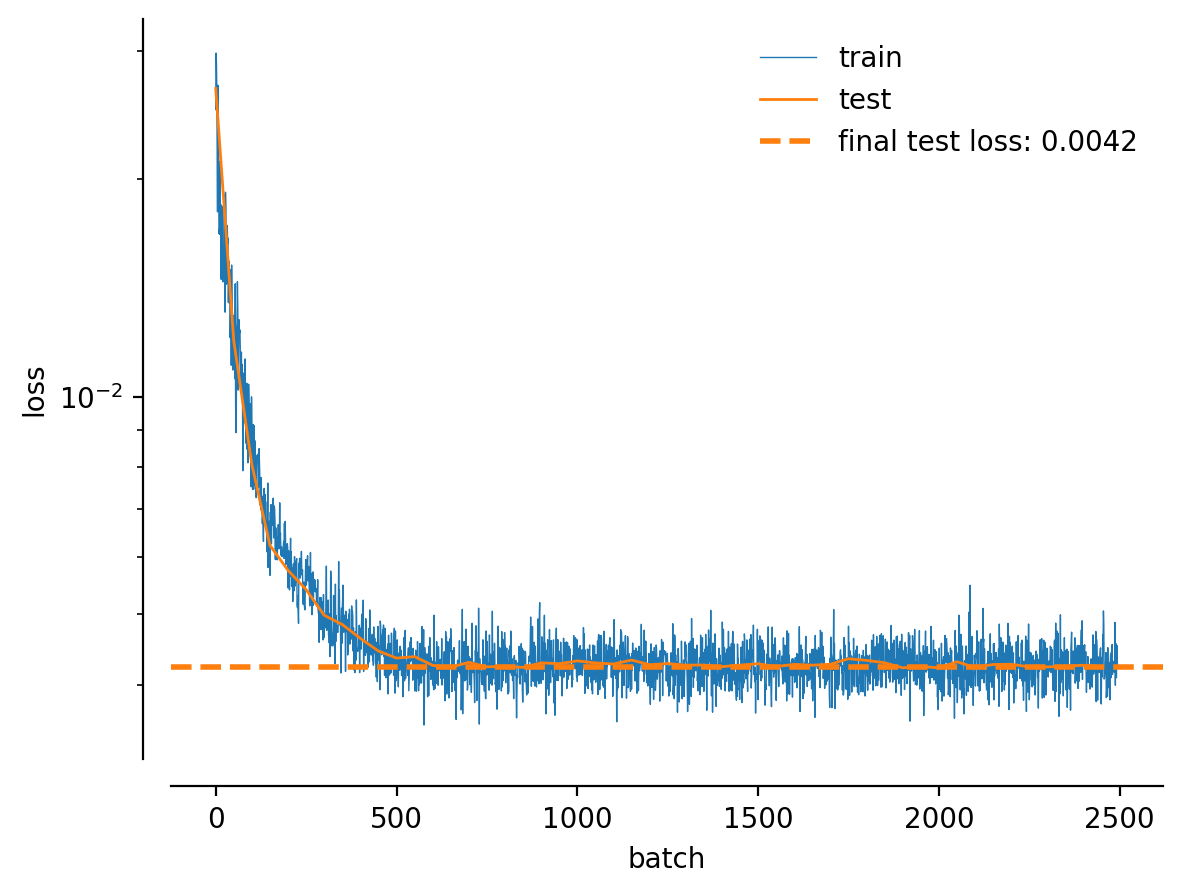

In [102]:
fig, ax = plt.subplots()
ax.semilogy(train_results.train_loss, lw=0.5, label="train")
ax.semilogy(train_results.test_idxs, train_results.test_loss, lw=1.0, label="test")
ax.set_xlabel("batch")
ax.set_ylabel("loss")

ax.axhline(
    train_results.test_loss[-1],
    lw=2.0,
    ls="--",
    c="C1",
    label=f"final test loss: {train_results.test_loss[-1]:.2g}"
)

ax.legend(frameon=False)

sns.despine(ax=ax, offset=10)

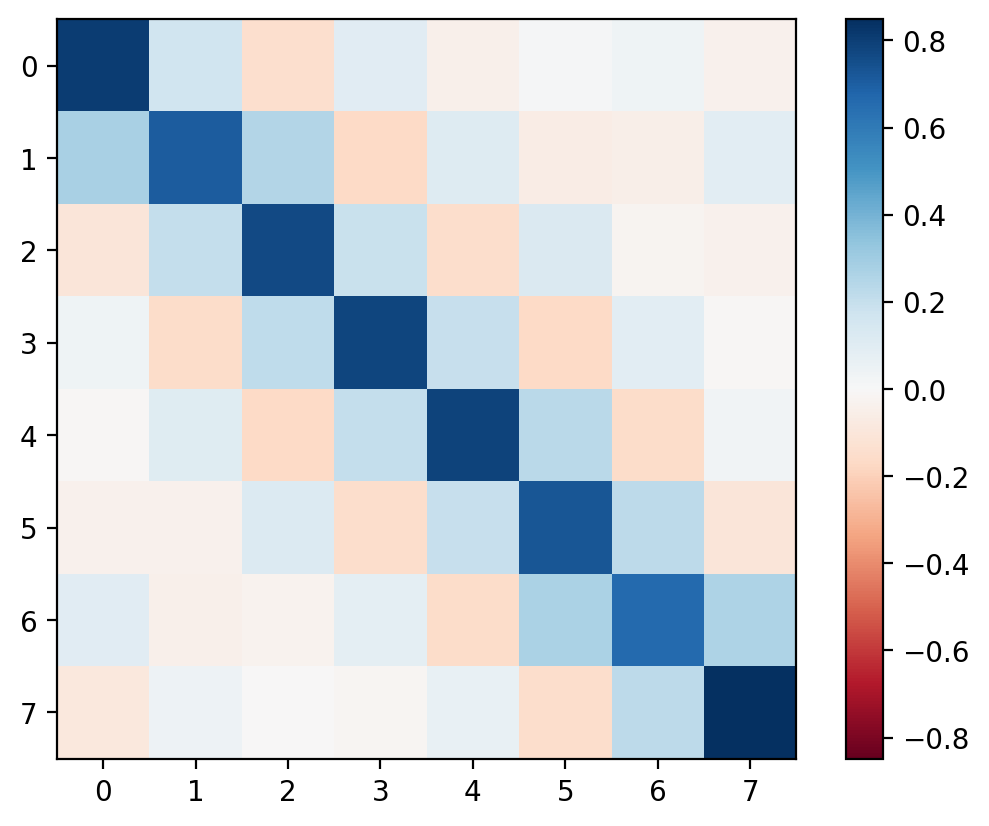

In [103]:
crt_tensor = (system.V @ system.U).detach().numpy()
crt_lim = np.max(np.abs(crt_tensor))
plt.imshow(crt_tensor, cmap="RdBu", vmin=-crt_lim, vmax=crt_lim)
plt.colorbar()

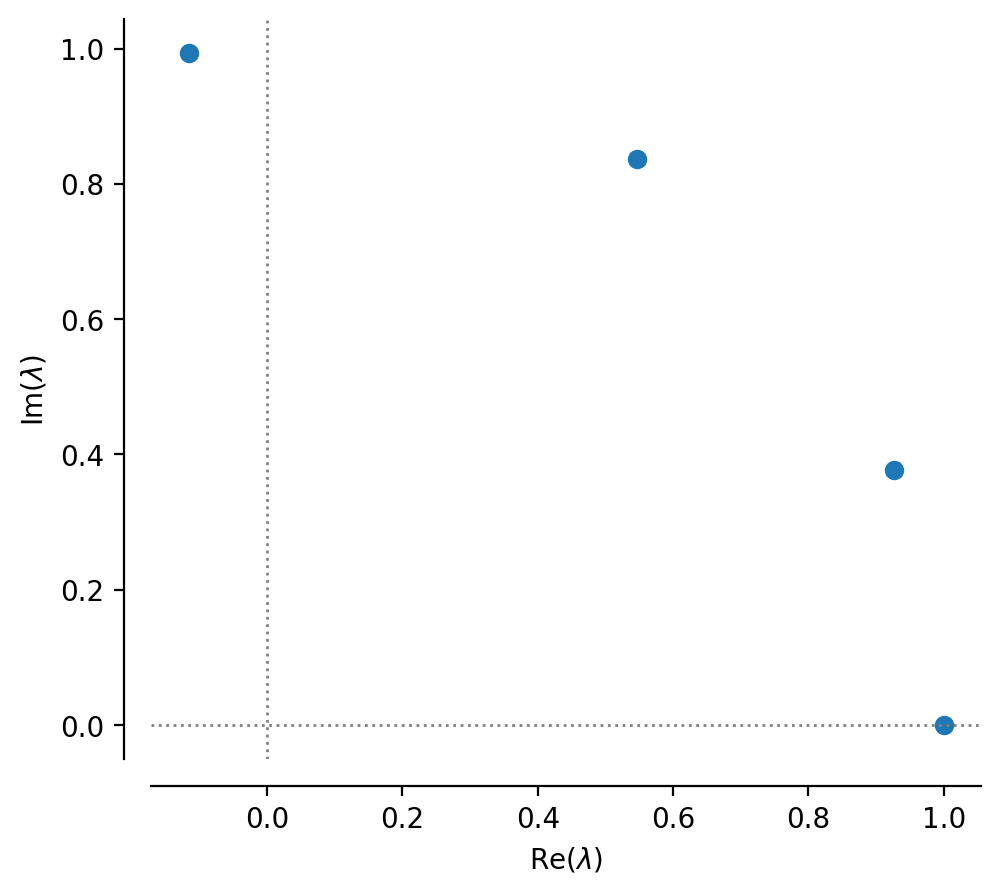

In [104]:
fig, ax = plt.subplots()
crt_rho = (1 / torch.cosh(system.xi)).detach().numpy()
crt_theta = system.theta.detach().numpy()
crt_v = crt_rho[:len(crt_theta)] * np.exp(1j * crt_theta)
if len(crt_rho) > len(crt_theta):
    crt_v = np.hstack((crt_v, [crt_rho[-1]]))

ax.axhline(0, ls=":", lw=1, c="gray")
ax.axvline(0, ls=":", lw=1, c="gray")

ax.scatter(crt_v.real, crt_v.imag)
ax.set_aspect(1)
ax.set_xlabel("Re($\\lambda$)")
ax.set_ylabel("Im($\\lambda$)")

sns.despine(ax=ax, offset=10)

In [105]:
(
    torch.max(torch.abs(system.U)),
    torch.max(torch.abs(system.V)),
)

(tensor(0.5119, grad_fn=<MaxBackward1>),
 tensor(1.0197, grad_fn=<MaxBackward1>))

### Try learned system on examples

In [106]:
torch.manual_seed(1)

test_simulator = PlaceGridMotionSimulator(n, sigma=0.5)

test_n_samples = 10
test_x = n * torch.rand(test_n_samples)
test_trajectory = []
for i in range(test_n_samples):
    test_simulator.x = test_x[i].item()
    test_trajectory.append(test_simulator().type(torch.float32))

test_trajectory = torch.stack(test_trajectory)

In [107]:
test_moved = system.propagate_place(test_trajectory, 2 * torch.ones(test_n_samples))

Text(0.5, 0, 'position')

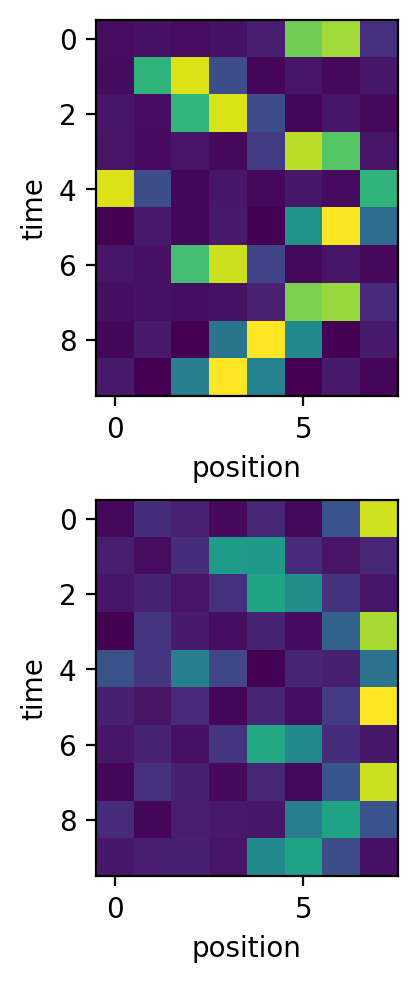

In [108]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.imshow(test_trajectory)
ax1.set_ylabel("time")
ax1.set_xlabel("position")

ax2.imshow(test_moved.detach().numpy())
ax2.set_ylabel("time")
ax2.set_xlabel("position")

In [109]:
[torch.min(torch.abs(system.xi)), torch.max(torch.abs(system.xi))]

[tensor(1.6814e-27, grad_fn=<MinBackward1>),
 tensor(0.0113, grad_fn=<MaxBackward1>)]

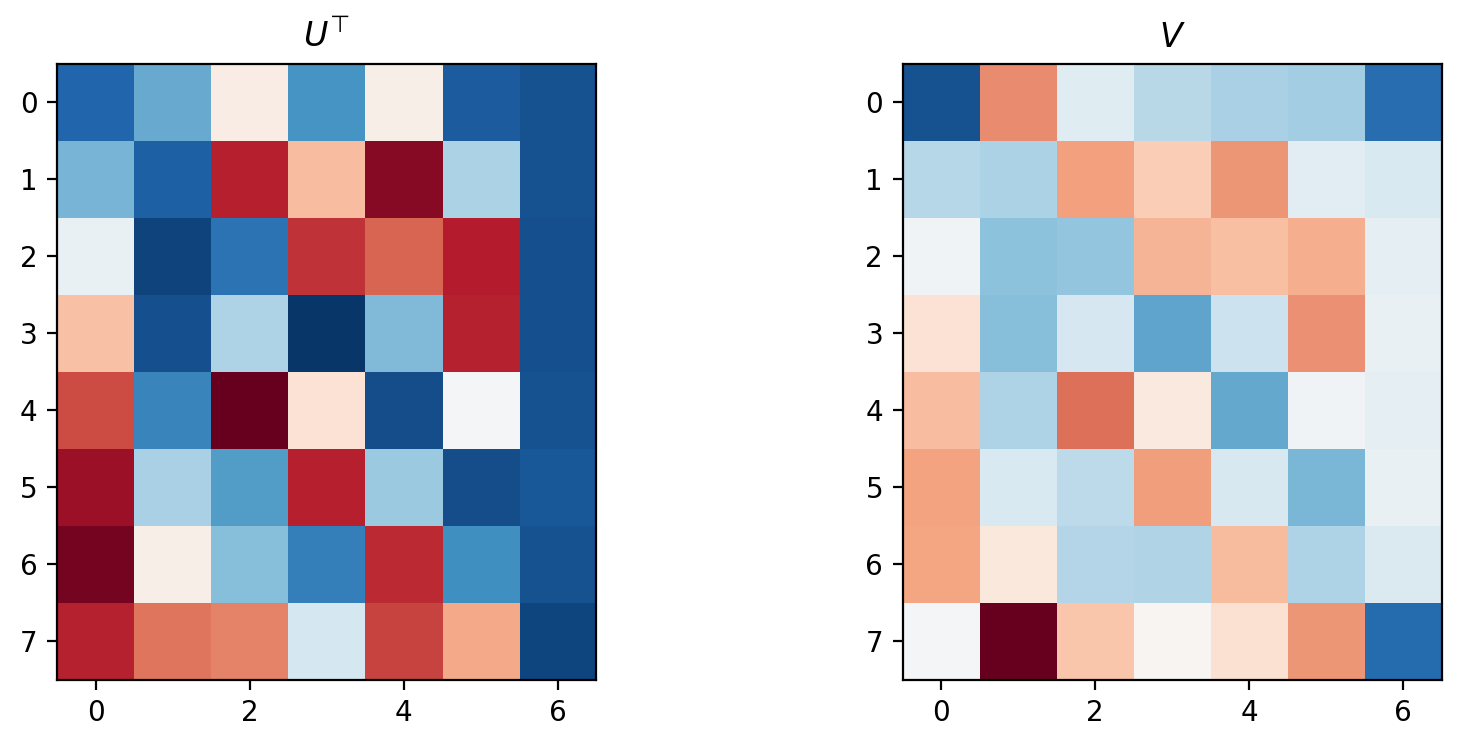

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
# crt_ordering = np.argsort(np.abs(system.theta.detach().numpy()))
for i, crt_name in enumerate(crt_d):
    crt_mat = crt_d[crt_name].detach().numpy()

    # crt_mat = crt_mat[:, crt_ordering]
    # crt_mat = crt_mat[crt_ordering, :]

    crt_lim = np.max(np.abs(crt_mat))
    
    ax = axs[i]
    ax.imshow(crt_mat, vmin=-crt_lim, vmax=crt_lim, cmap="RdBu")

    ax.set_title(crt_name)

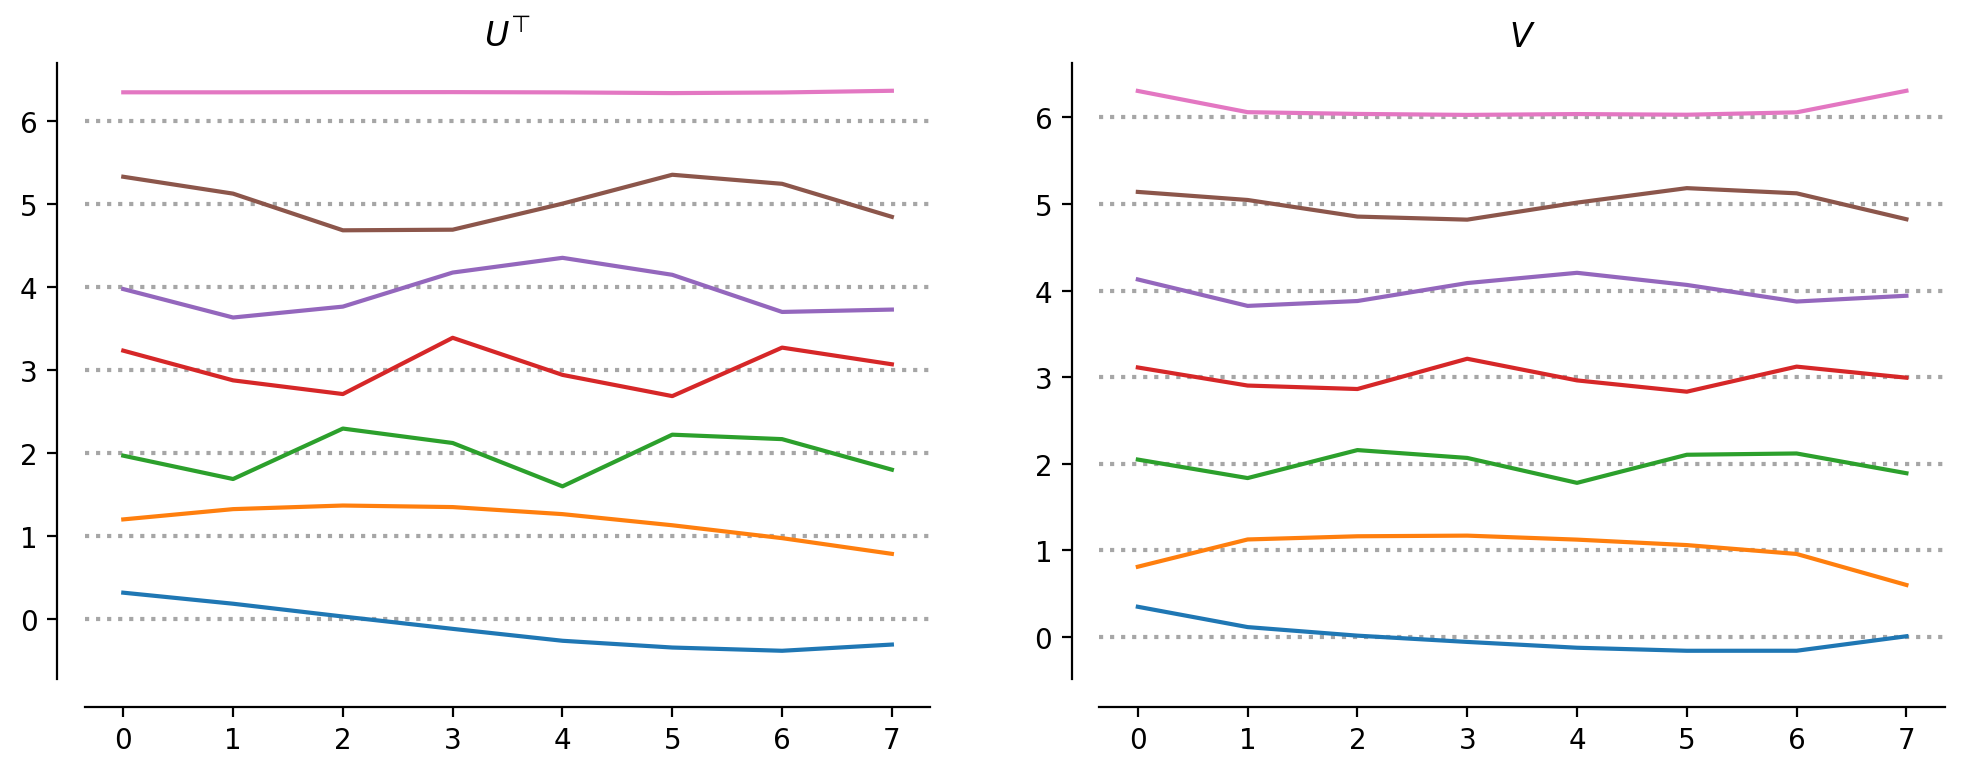

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
crt_d = {"$U^\\top$": system.U.T, "$V$": system.V}
for i, crt_name in enumerate(crt_d):
    ax = axs[i]
    crt_mat = crt_d[crt_name].detach().numpy()
    crt_lim = np.max(np.abs(crt_mat))
    for k in range(m):
        crt_v = crt_mat[:, k]
        ax.axhline(k, ls=":", c="gray", alpha=0.7)
        ax.plot(np.arange(n), k + 0.4 * crt_v / crt_lim)
    
    ax.set_title(crt_name)
    sns.despine(ax=ax, offset=10)

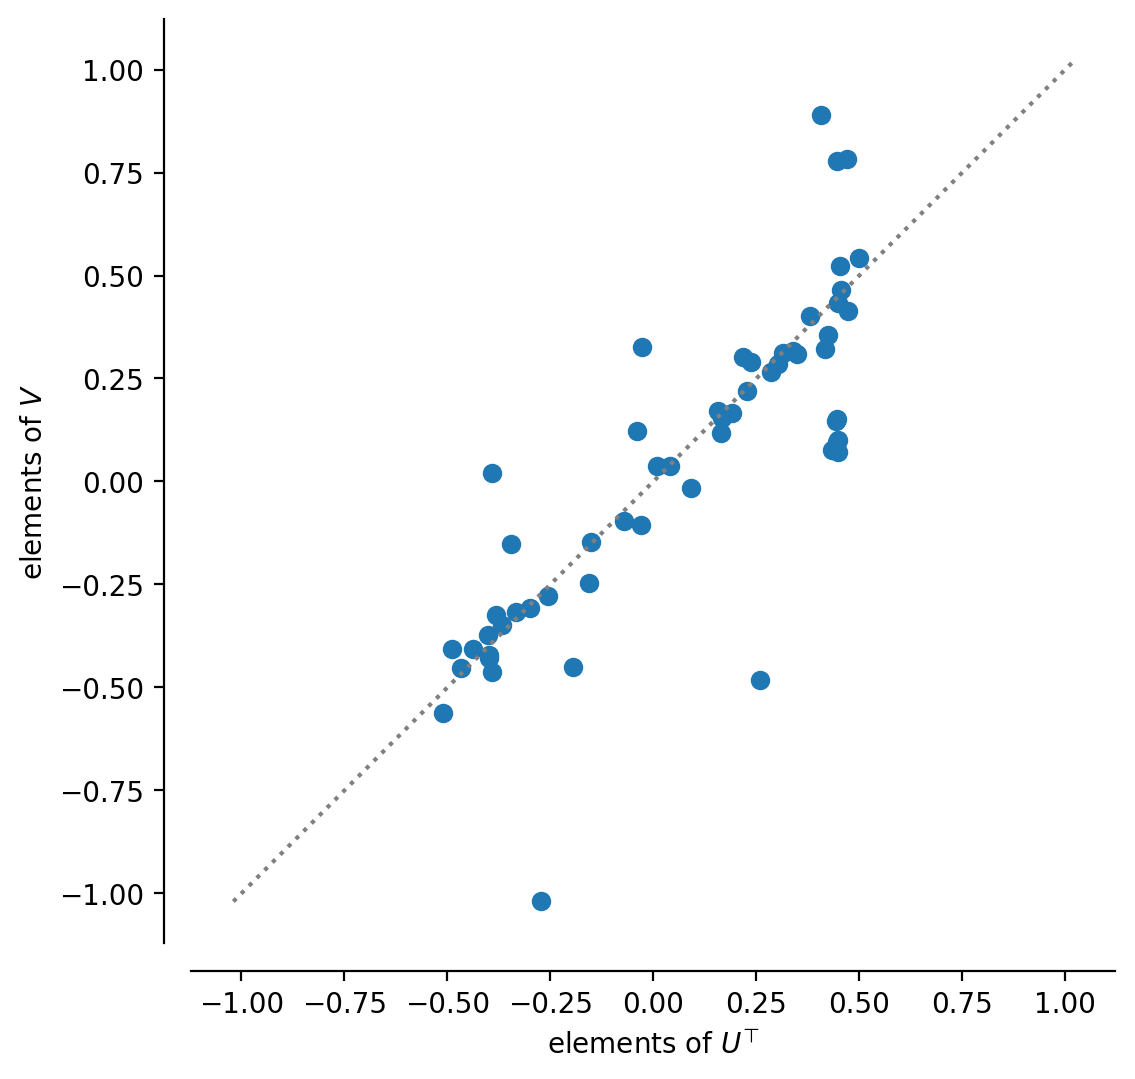

In [112]:
fig, ax = plt.subplots(figsize=(6, 6))
crt_u = system.U.detach().numpy()
crt_vt = system.V.T.detach().numpy()
crt_lim = max(np.max(np.abs(_)) for _ in [crt_u, crt_vt])
ax.plot([-crt_lim, crt_lim], [-crt_lim, crt_lim], c="gray", ls=":")
ax.scatter(crt_u, crt_vt)
ax.set_xlabel("elements of $U^\\top$")
ax.set_ylabel("elements of $V$")

ax.set_aspect(1)
sns.despine(ax=ax, offset=10)

## Check Fourier translation on von-Mises

In [113]:
n = 8
fourier_U = np.array(
    [
        [1 / np.sqrt(n) * np.exp(2 * np.pi * k * l / n * 1j) for k in range(n)]
        for l in range(n)
    ]
)
fourier_V = fourier_U.conj().T

In [114]:
(
    np.max(np.abs(fourier_U @ fourier_V - np.eye(n))),
    np.max(np.abs(fourier_V @ fourier_U - np.eye(n))),
)

(7.0680425963108e-16, 7.0680425963108e-16)

In [115]:
def fourier_translate(x, s: float) -> np.ndarray:
    n = len(x)
    # turns out the ** operator has the right branch cut to maket this work
    lbd = np.exp(-(2j * np.pi / n) * np.arange(n)) ** s

    # need to zero out highest frequency mode if n is even
    if n % 2 == 0:
        lbd[n // 2] = 0

    x_f = fourier_V @ x
    x_f_shifted = lbd * x_f
    x_shifted = fourier_U @ x_f_shifted
    
    assert np.max(np.abs(x_shifted.imag)) < 1e-6

    return x_shifted.real

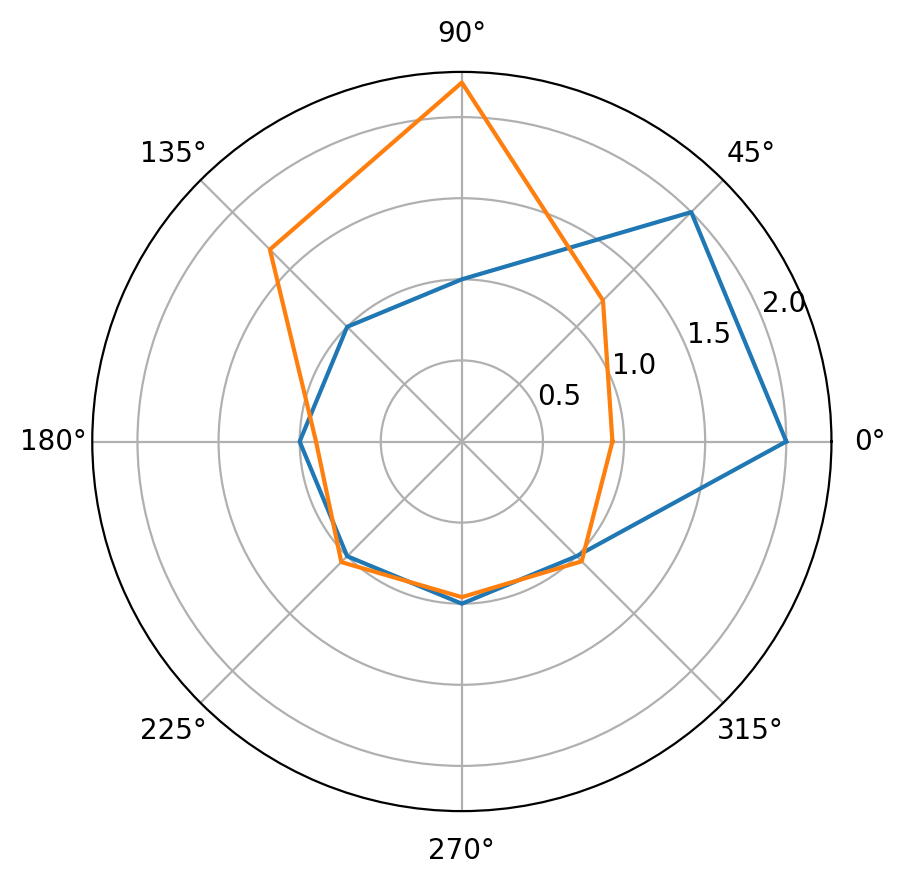

In [116]:
crt_s = 1.7
crt_v0 = np.hstack(([1, 1], np.zeros(n - 2)))
crt_v1 = fourier_translate(crt_v0, crt_s)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v0, crt_v0[[0]])), c="C0")
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v1, crt_v1[[0]])), c="C1")

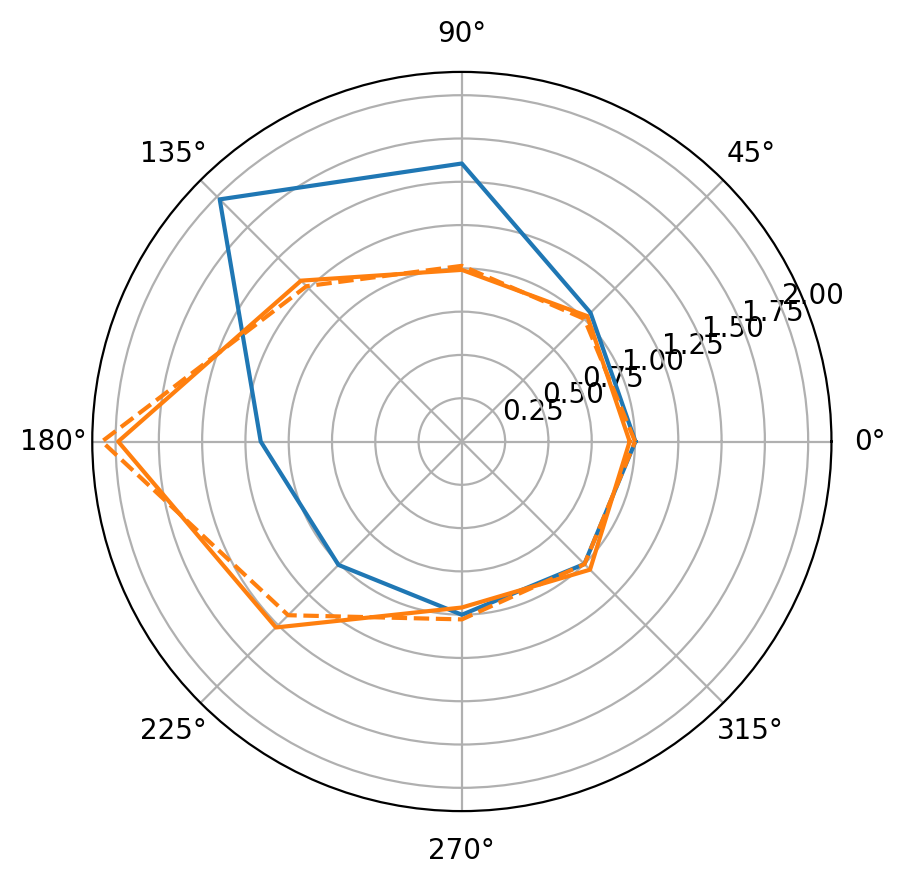

In [117]:
crt_x0 = 2.7
crt_cos = np.cos(2 * np.pi * (np.arange(n) - crt_x0) / n)
crt_kappa = 1 / 0.5 ** 2
crt_v0 = 0.02 * np.exp(crt_kappa * crt_cos)

crt_s = 1.4
crt_v1 = fourier_translate(crt_v0, crt_s)

# what if we had shifted the von Mises?
crt_cos_tgt = np.cos(2 * np.pi * (np.arange(n) - crt_x0 - crt_s) / n)
crt_v1_tgt = 0.02 * np.exp(crt_kappa * crt_cos_tgt)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v0, crt_v0[[0]])), c="C0")
ax.plot(np.arange(n + 1) / n * 2 * np.pi, 1 + np.hstack((crt_v1, crt_v1[[0]])), c="C1")
ax.plot(
    np.arange(n + 1) / n * 2 * np.pi,
    1 + np.hstack((crt_v1_tgt, crt_v1_tgt[[0]])),
    c="C1",
    ls="--",
)

In [118]:
np.max(np.abs(crt_v1 - crt_v1_tgt))

0.10009610051255691

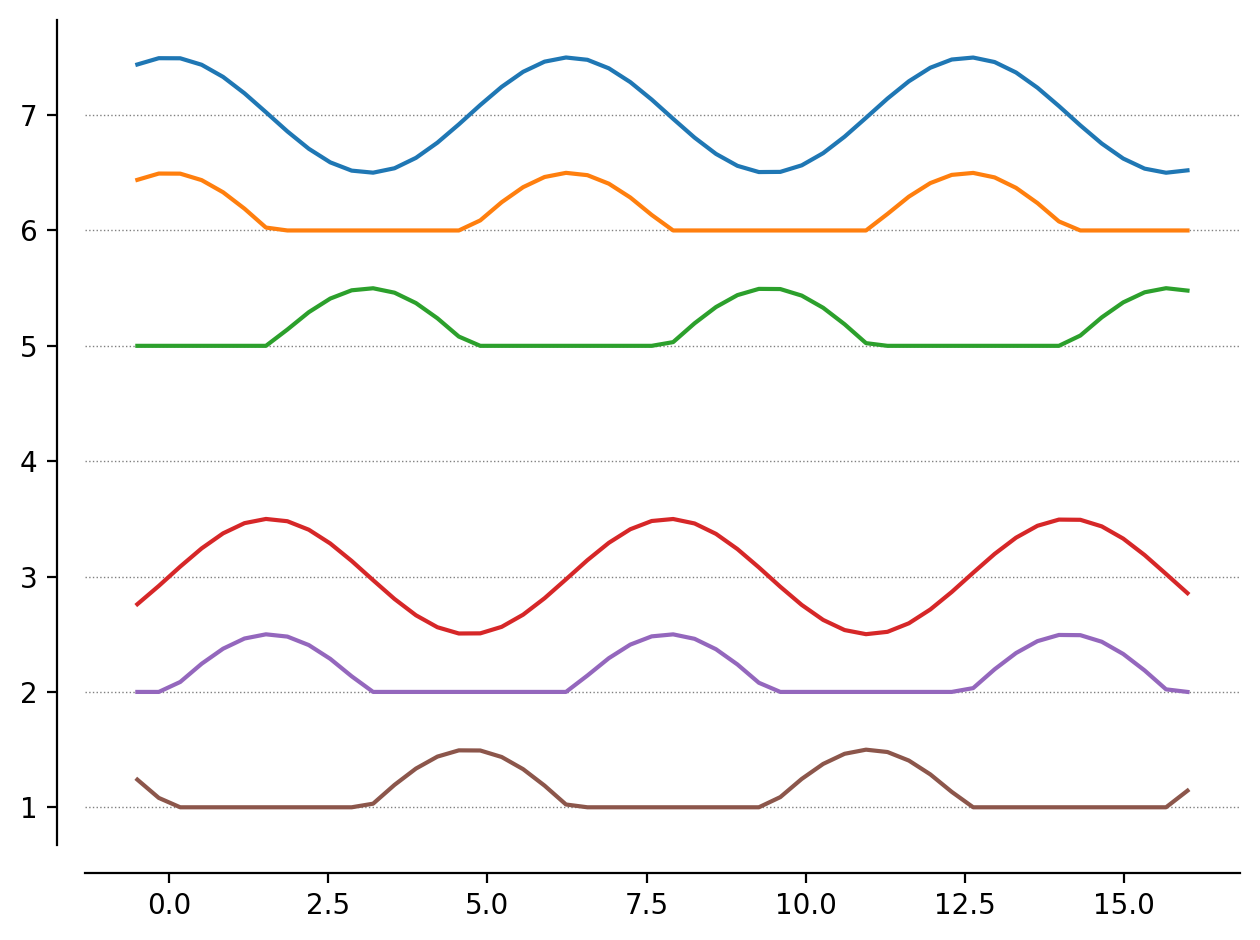

In [119]:
with dv.FigureManager() as (_, ax):
    crt_x = np.linspace(-0.5, 16.0)
    crt_cos = 0.5 * np.cos(crt_x)
    crt_sin = 0.5 * np.sin(crt_x)
    
    for i in range(1, 8):
        ax.axhline(i, ls=":", lw=0.5, c="gray")
        
    ax.plot(crt_x, crt_cos + 7)
    ax.plot(crt_x, np.clip(crt_cos, 0, None) + 6)
    ax.plot(crt_x, -np.clip(crt_cos, None, 0) + 5)
    
    ax.plot(crt_x, crt_sin + 3)
    ax.plot(crt_x, np.clip(crt_sin, 0, None) + 2)
    ax.plot(crt_x, -np.clip(crt_sin, None, 0) + 1)